# Check How Tanimoto Distances are Distributed

<hr/>

## Prerequisites

#### Imports

In [1]:
import os
import shutil
import sys

import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import tensorflow as tf

from datetime import datetime

from ensemble_uncertainties.evaluators.evaluator_support import format_time_elapsed, make_columns
from ensemble_uncertainties.evaluators.regression_evaluator import RegressionEvaluator
from ensemble_uncertainties.model_library import models
from ensemble_uncertainties.utils.ad_assessment import rmses_frac
from ensemble_uncertainties.utils.kernel_functions import tanimoto

from matplotlib.font_manager import FontProperties

from sklearn.covariance import EmpiricalCovariance
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

#### Constants

In [2]:
RANDOM_SEED = 0
N_SPLITS = 2
TASK = 'regression'
PLOT_FOLDER = './plots/tanimoto/'

BLACK = [0, 0, 0]
RED = [1, 0, 0]
GREY = [.6, .6, .6]

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

#### Functions

In [4]:
def tanimoto_distance(A, B):
    """Computes Tanimoto distance for two bit vectors."""
    return 1 - tanimoto(A, B)


def load_data_set(name, descriptor):
    """Loads X and y as dataframes from data folder."""
    folder = f'../../../data/featurized/{TASK}/{name}/'
    X_file = f'{folder}{name}_{descriptor}.csv'
    y_file = f'{folder}{name}_y.csv'
    X = pd.read_csv(X_file, sep=';').set_index('id')
    y = pd.read_csv(y_file, sep=';').set_index('id')
    return X, y


def single_distribution(distances, index):
    """Plots the distrubion of distances for a single object."""
    plt.grid(zorder=1000)
    plt.hist(distances[index], bins=100, zorder=100)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Result of $\mathtt{tanimoto()}$, for object ' + str(index))
    plt.show()
        
            
def compute_cv_tanimoto(X, y, repetitions, n_splits):
    """Computes multiple cross-validated Tanimoto distances."""
    tanimotos = pd.DataFrame()
    start_time = datetime.now()
    for rep_index in tqdm(range(repetitions)):
        kfold = KFold(n_splits=n_splits,
            random_state=rep_index, shuffle=True)
        splits = kfold.split(X)
        split_iter = list(enumerate(splits))
        for split_index, (train_id, test_id) in split_iter:
            # Select train and test fraction
            X_train, X_test = X.iloc[train_id], X.iloc[test_id]
            all_tanimoto = tanimoto_distance(X_train, X_test)
            median_tanimoto = np.median(all_tanimoto, axis=0)
            median_tanimoto_df = pd.DataFrame(median_tanimoto, index=X_test.index)
            tanimotos = pd.concat([tanimotos, median_tanimoto_df], axis=1)
    tanimotos.columns = make_columns(repetitions, n_splits)
    tanimotos_time = datetime.now() - start_time
    return tanimotos, tanimotos_time


def run_evaluation(X, y, model_name, repetitions, n_splits):
    """Performs a run with the RegressionEvaluator."""
    evaluator = RegressionEvaluator(
        model=models['regression'][model_name],
        repetitions=repetitions,
        n_splits=n_splits,
        verbose=False,
        scale=False
    )
    evaluator.perform(X, y)
    resids = evaluator.test_ensemble_preds['resid']
    uncertainties = evaluator.test_ensemble_preds['sdep']
    evaluator_time = evaluator.overall_run_time
    return resids, uncertainties, evaluator_time


def plot_comparison(oracle_rmses, measure_rmses, tanimoto_rmses, evaluator_time, tanimotos_time, title, ax1, ax2, fig):
    """Plots confidence curves for several evaluators."""
    n_splitss = list()
    times = list()
    formatted_times = list()
    # Plot uncertainty performances
    ax1.grid(zorder=1000)
    x_space = np.linspace(0.0, 100.0, len(oracle_rmses))
    ax1.plot(x_space, oracle_rmses, zorder=100, color=BLACK,
        label=f'Oracle')
    ax1.plot(x_space, measure_rmses, zorder=100, color=RED,
        label=f'SDEP')
    ax1.plot(x_space, tanimoto_rmses, zorder=100, color=GREY,
        label=f'Med. Tanim.')
    ax1.set_title(title)
    ax1.set_xlabel('Percentile')
    ax1.set_ylabel('$RMSE$')
    ax1.legend()
    # Plot times
    ax2.grid(zorder=1000)
    times = [evaluator_time.total_seconds(), tanimotos_time.total_seconds()]
    evaluator_time_formatted = format_time_elapsed(evaluator_time).replace('.', '\n')
    tanimotos_time_formatted = format_time_elapsed(tanimotos_time).replace('.', '\n')
    formatted_times = [
        evaluator_time_formatted if evaluator_time_formatted else '< 1 second',
        # Whitespace must be added at the end for formatting of the bars
        tanimotos_time_formatted if tanimotos_time_formatted else '< 1 second '
    ]
    ax2.bar(formatted_times, times, zorder=100, label='',
        color=[RED, GREY])
    ax2.set_title('')
    ax2.set_xlabel('')
    ax2.set_ylabel('Runtime [s]')     
    colors = dict(zip(['SDEP', 'Med. Tanim.'], [RED, GREY]))        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax2.legend(handles, labels)
    # Re-arrange legends to last axis, so that the legend stays ontop
    all_axes = fig.get_axes()
    for axis in all_axes:
        legend = axis.get_legend()
        if legend is not None:
            legend.remove()
            all_axes[-1].add_artist(legend)


def compare_median(name, descriptor, model_names, repetitions, n_splits=N_SPLITS, plots_folder=PLOT_FOLDER):
    """Compares the median of the Tanimoto distance to the ensemble uncertainty."""
    X, y = load_data_set(name, descriptor)
    print('Computing Tanimoto distances.')
    tanimotos, tanimotos_time = compute_cv_tanimoto(X, y, repetitions, n_splits)
    tanimotos_median = tanimotos.median(axis=1)
    print('Running evaluators.')
    # Prepare plotting
    n_methods = len(model_names)
    fig, pre_axes = plt.subplots(2, n_methods, figsize=(5*n_methods, 10))
    # Transpose axes
    axes = zip(*pre_axes)
    for model_name, ax in zip(model_names, axes):
        print(f'At {model_name}.')
        uax, tax = ax
        resids, uncertainties, evaluator_time = run_evaluation(X, y, model_name, repetitions, n_splits)
        oracle_rmses, measure_rmses = rmses_frac(resids, uncertainties)
        _, tanimoto_rmses = rmses_frac(resids, tanimotos_median)
        title = f'{name}, {descriptor},\n{model_name}'
        plot_comparison(oracle_rmses, measure_rmses, tanimoto_rmses, evaluator_time, tanimotos_time, title, uax, tax, fig)
    print('Plotting.')
    if plots_folder:
        image_path = f'{plots_folder}{name}_{descriptor}_{"_".join(model_names)}_{repetitions}reps.png'
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.01)
    plt.show()

<hr/>

## Evaluate

Small test run over all entries of the MACCS-featurized Tetrahymena test set

In [5]:
# Load
tetrah_maccs, tetrah_y = load_data_set('tetrahymena', 'maccs')
# Compute Tanimoto
tanimoto_tetrah_maccs = tanimoto_distance(tetrah_maccs, tetrah_maccs)

Check all distributions

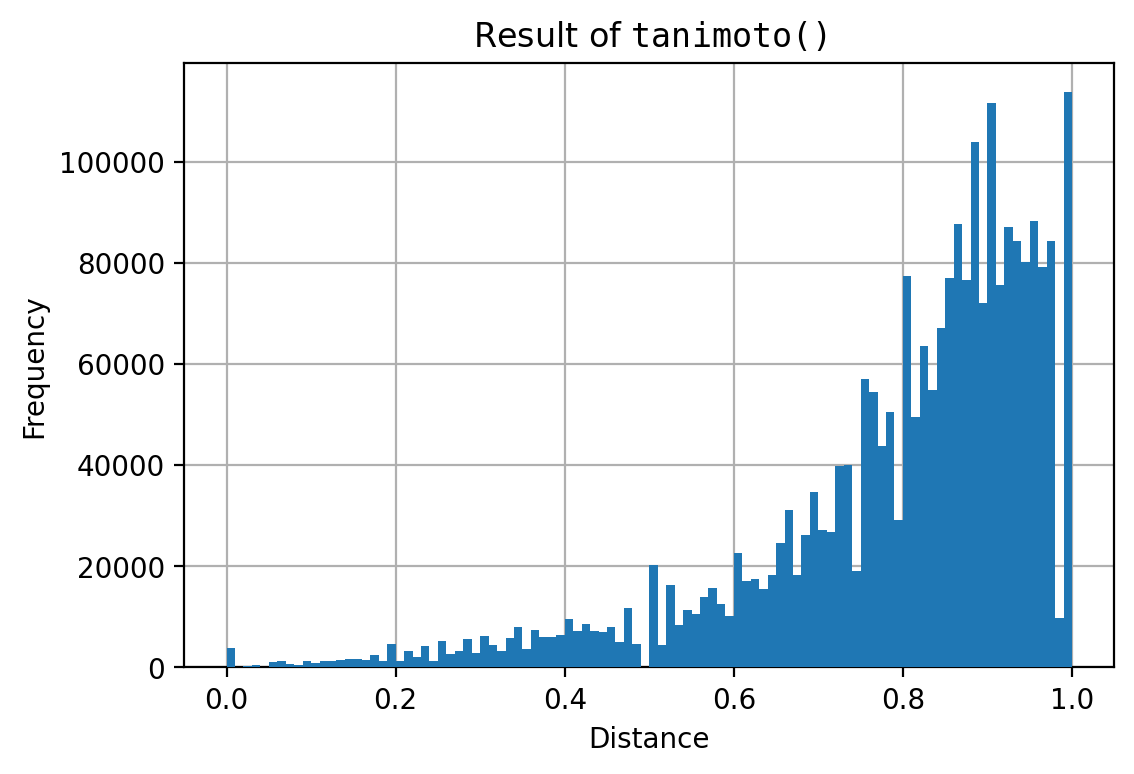

In [6]:
# Visualize distribution
plt.grid(zorder=1000)
plt.hist(tanimoto_tetrah_maccs.reshape(-1), bins=100, zorder=100)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Result of $\mathtt{tanimoto()}$')
plt.show()

Check single distributions

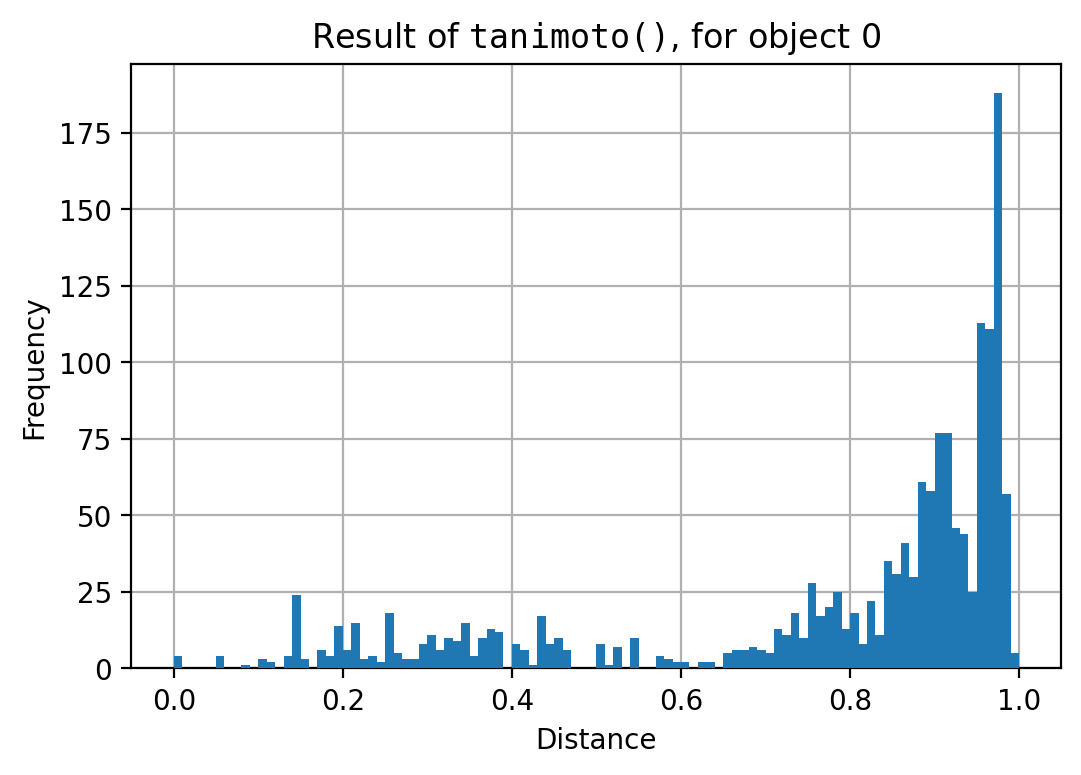

In [7]:
single_distribution(tanimoto_tetrah_maccs, 0)

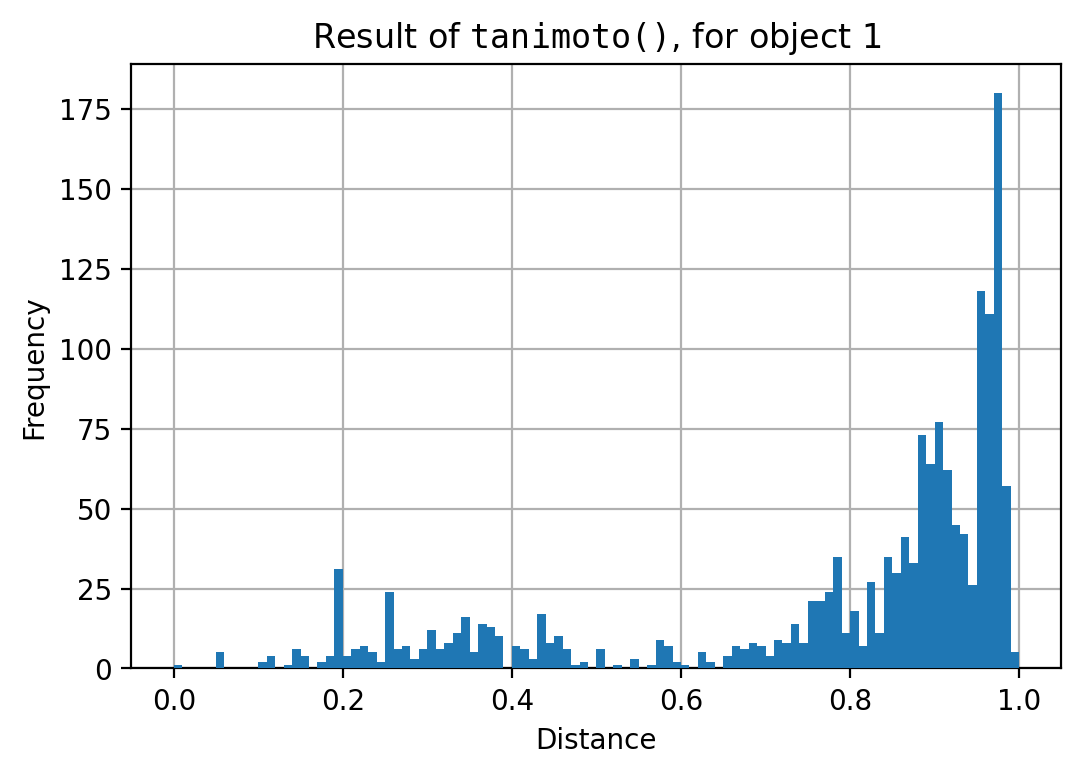

In [8]:
single_distribution(tanimoto_tetrah_maccs, 1)

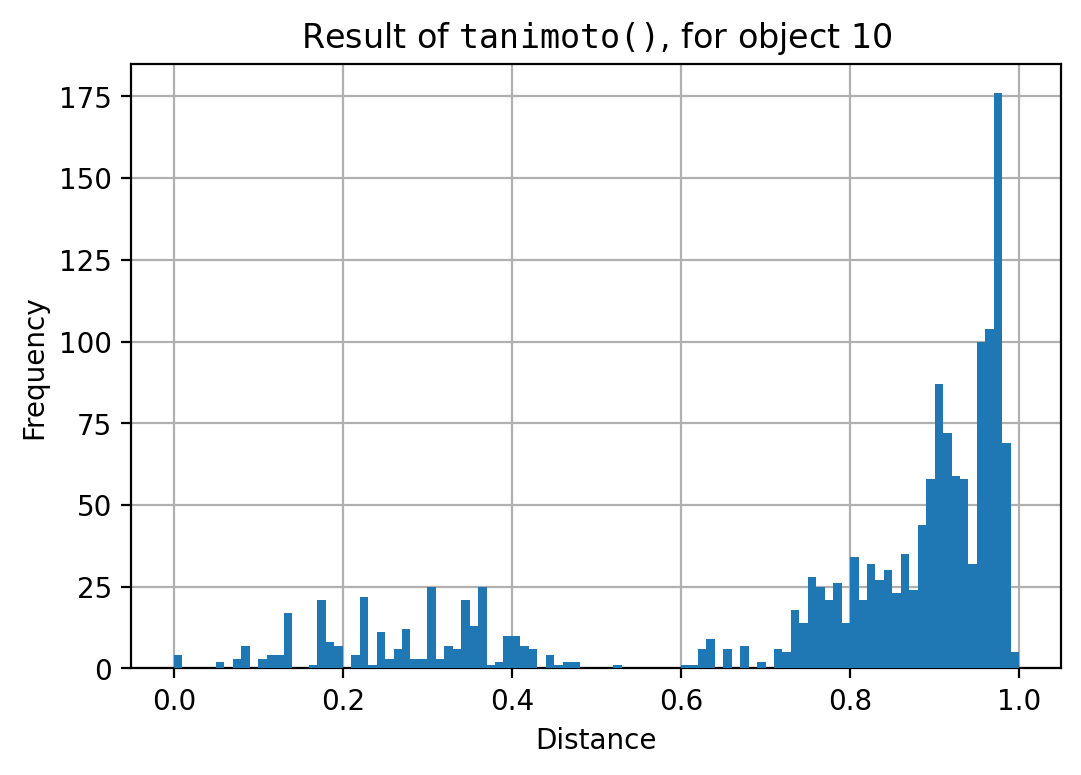

In [9]:
single_distribution(tanimoto_tetrah_maccs, 10)

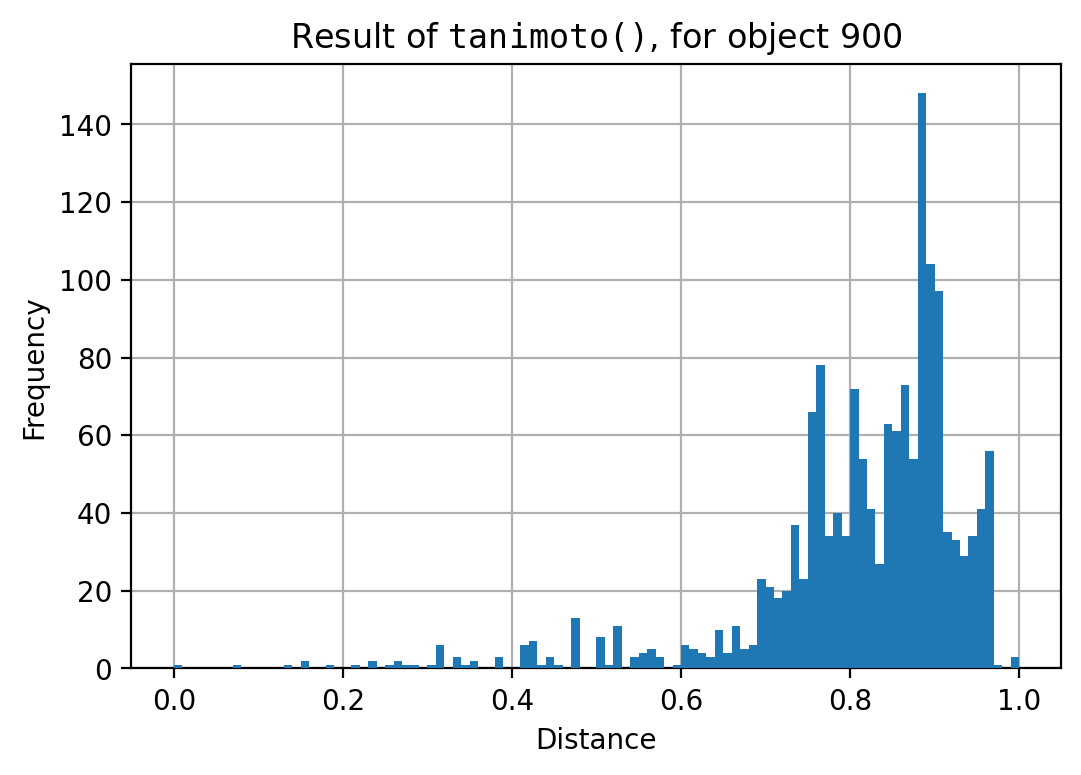

In [10]:
single_distribution(tanimoto_tetrah_maccs, 900)

Distributions do not look normal-distributed. Check if averaged distances are normal-distributed.

<hr/>

Try average Tanimoto similarity

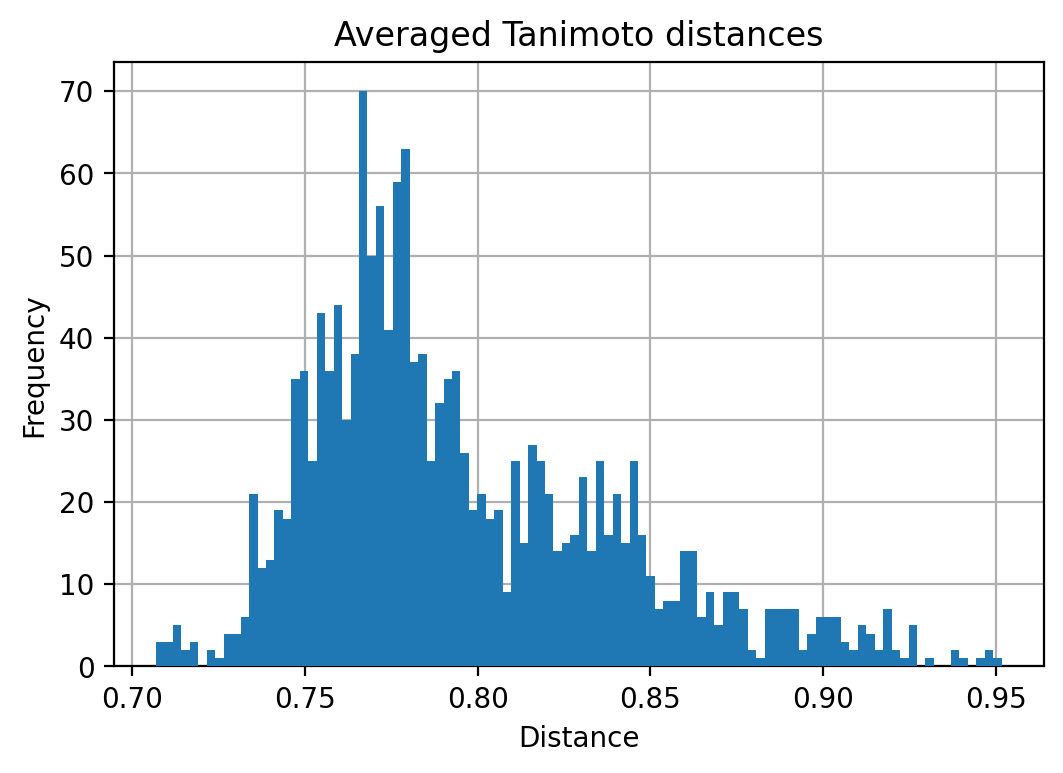

In [11]:
# Visualize distribution
plt.grid(zorder=1000)
plt.hist(tanimoto_tetrah_maccs.mean(axis=0), bins=100, zorder=100)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Averaged Tanimoto distances')
plt.show()

Just like Mahalanobis distances, the averaged Tanimoto distances to not look normal-distributed. Try median of medians, just to go sure.

<hr/>

#### Check whether the median over multiple Tanimoto distances per molecule is a meaningful novelty detection measure

  0%|          | 0/10 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/10 [00:00<?, ?it/s]

Running evaluators.
At xgb.


  0%|          | 0/10 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/10 [00:00<?, ?it/s]

At deep.


100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


Plotting.


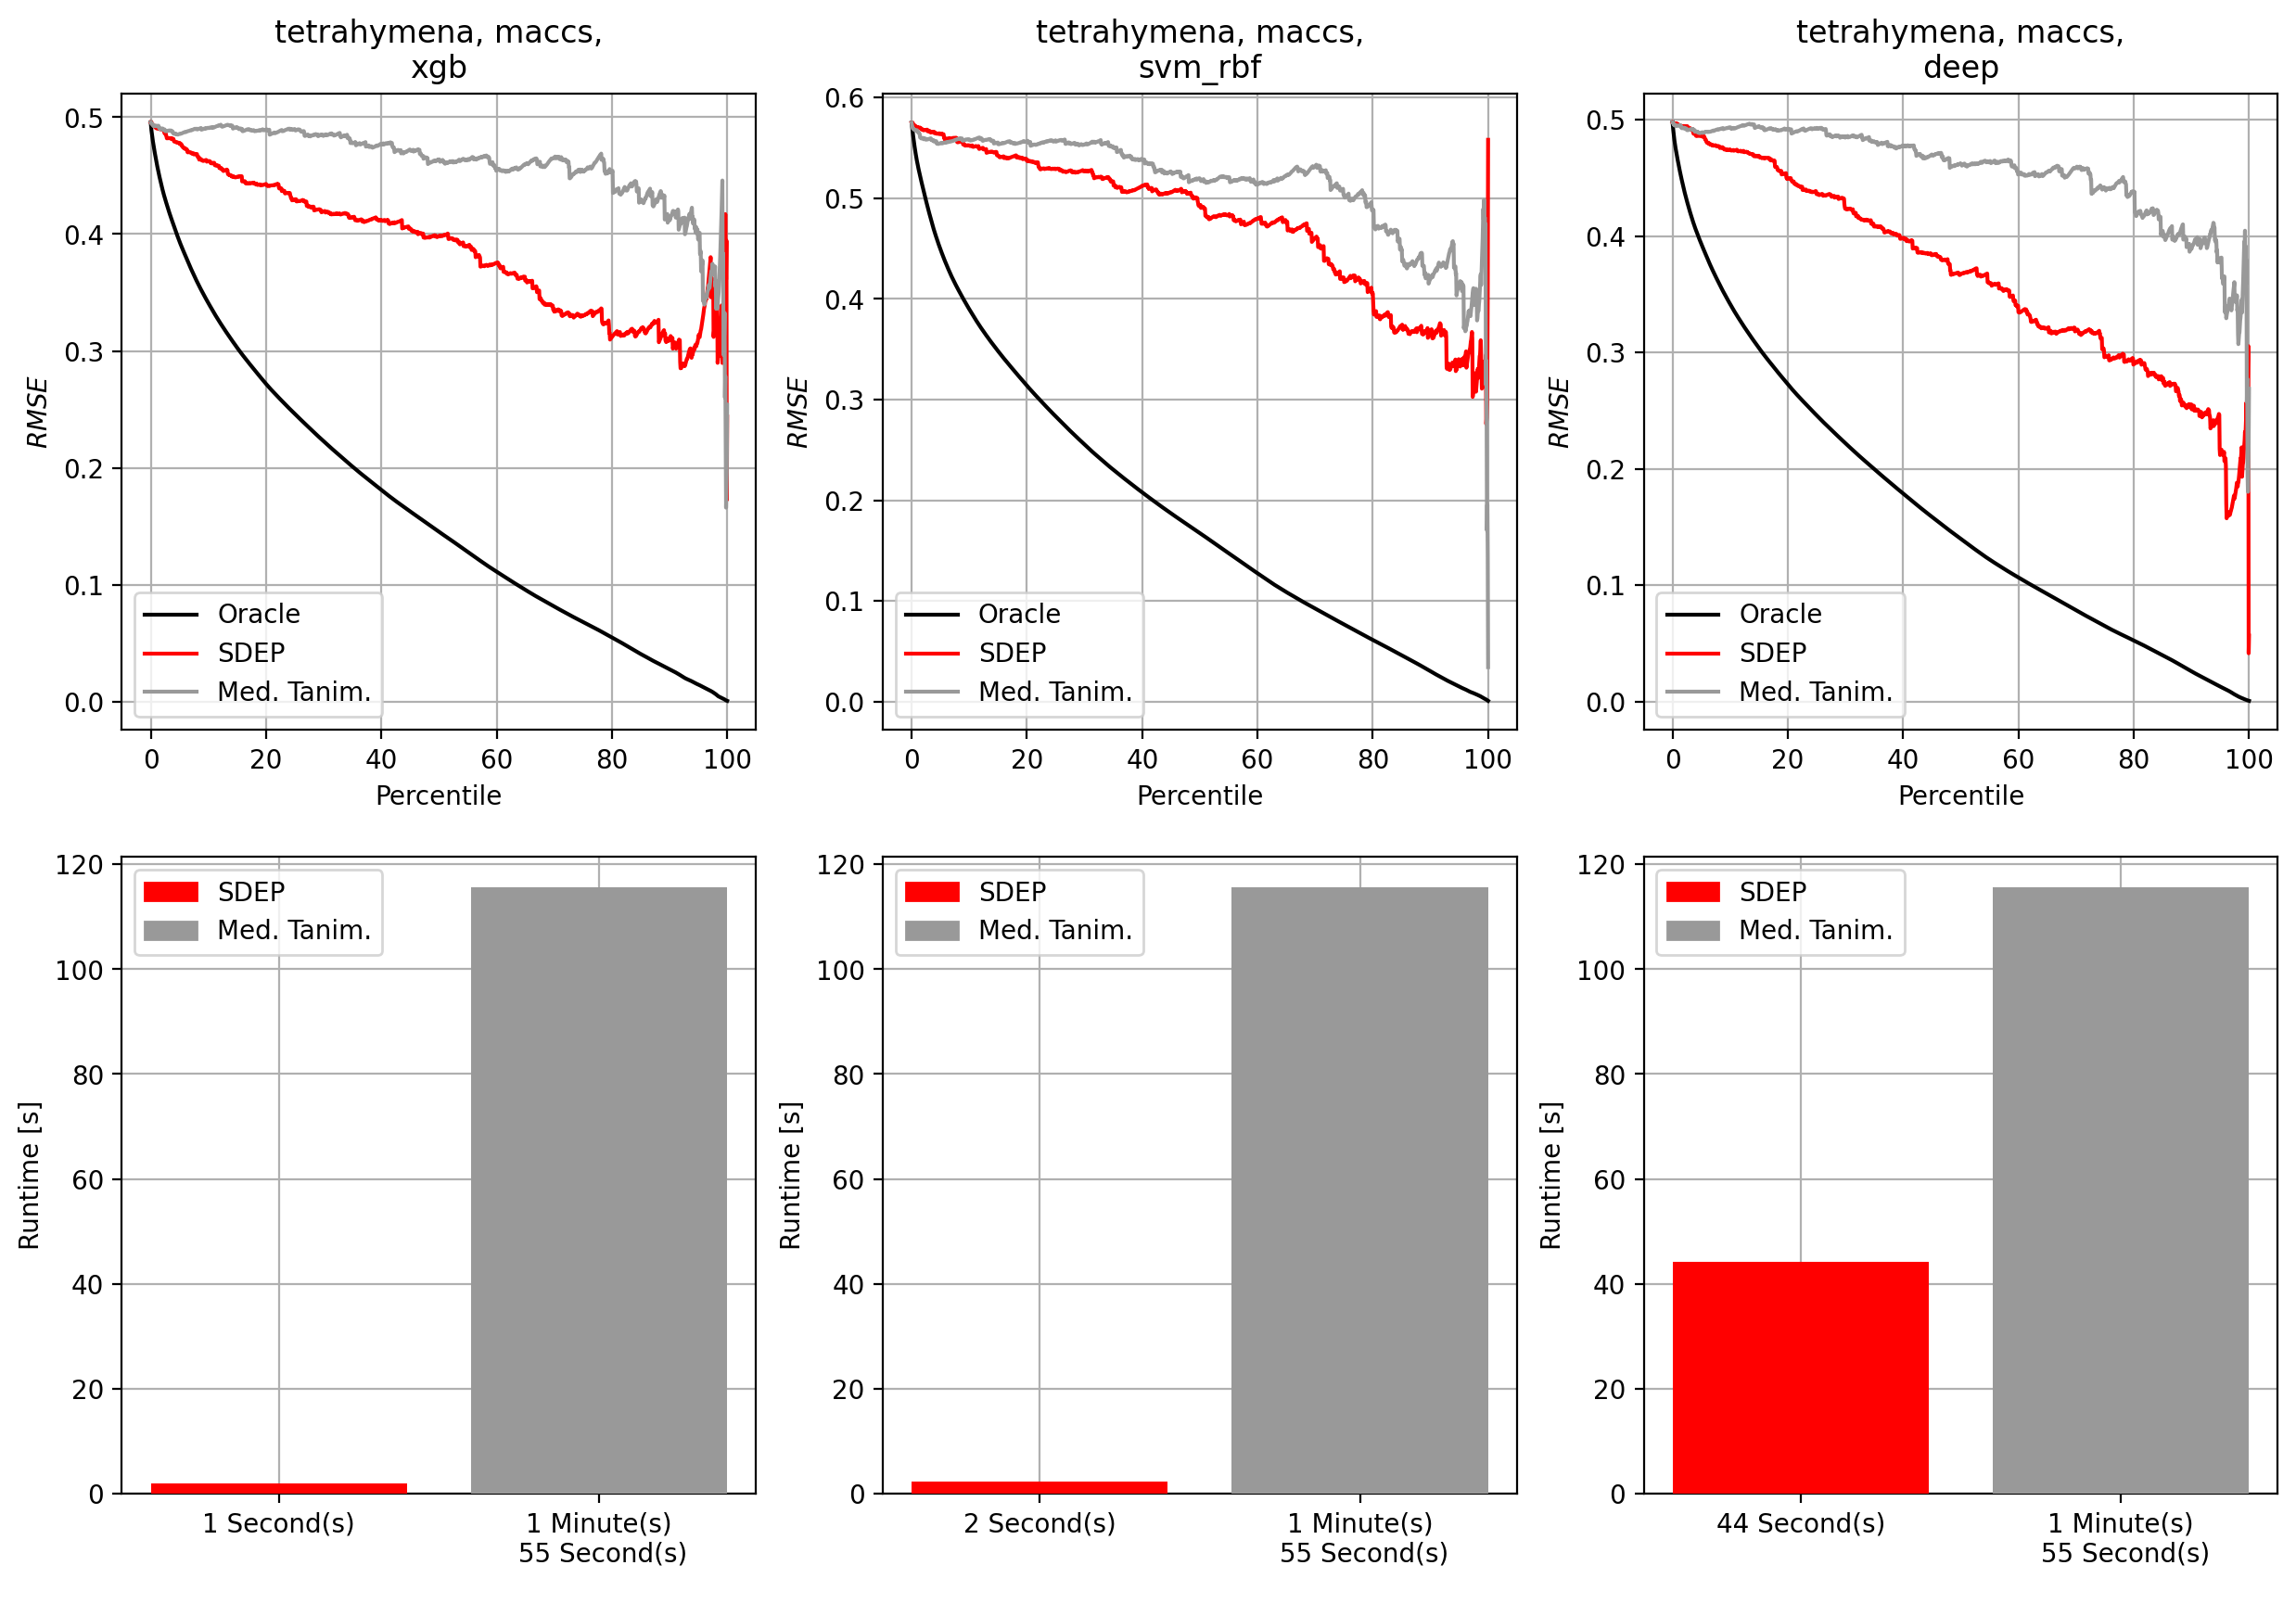

In [12]:
compare_median('tetrahymena', 'maccs', ['xgb', 'svm_rbf', 'deep'], 10)

Looks acceptable. Let's use the median and try out even more examples, for several settings.

<hr/>

## Run full Evaluation

### Tetrahymena, MACCS, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Plotting.


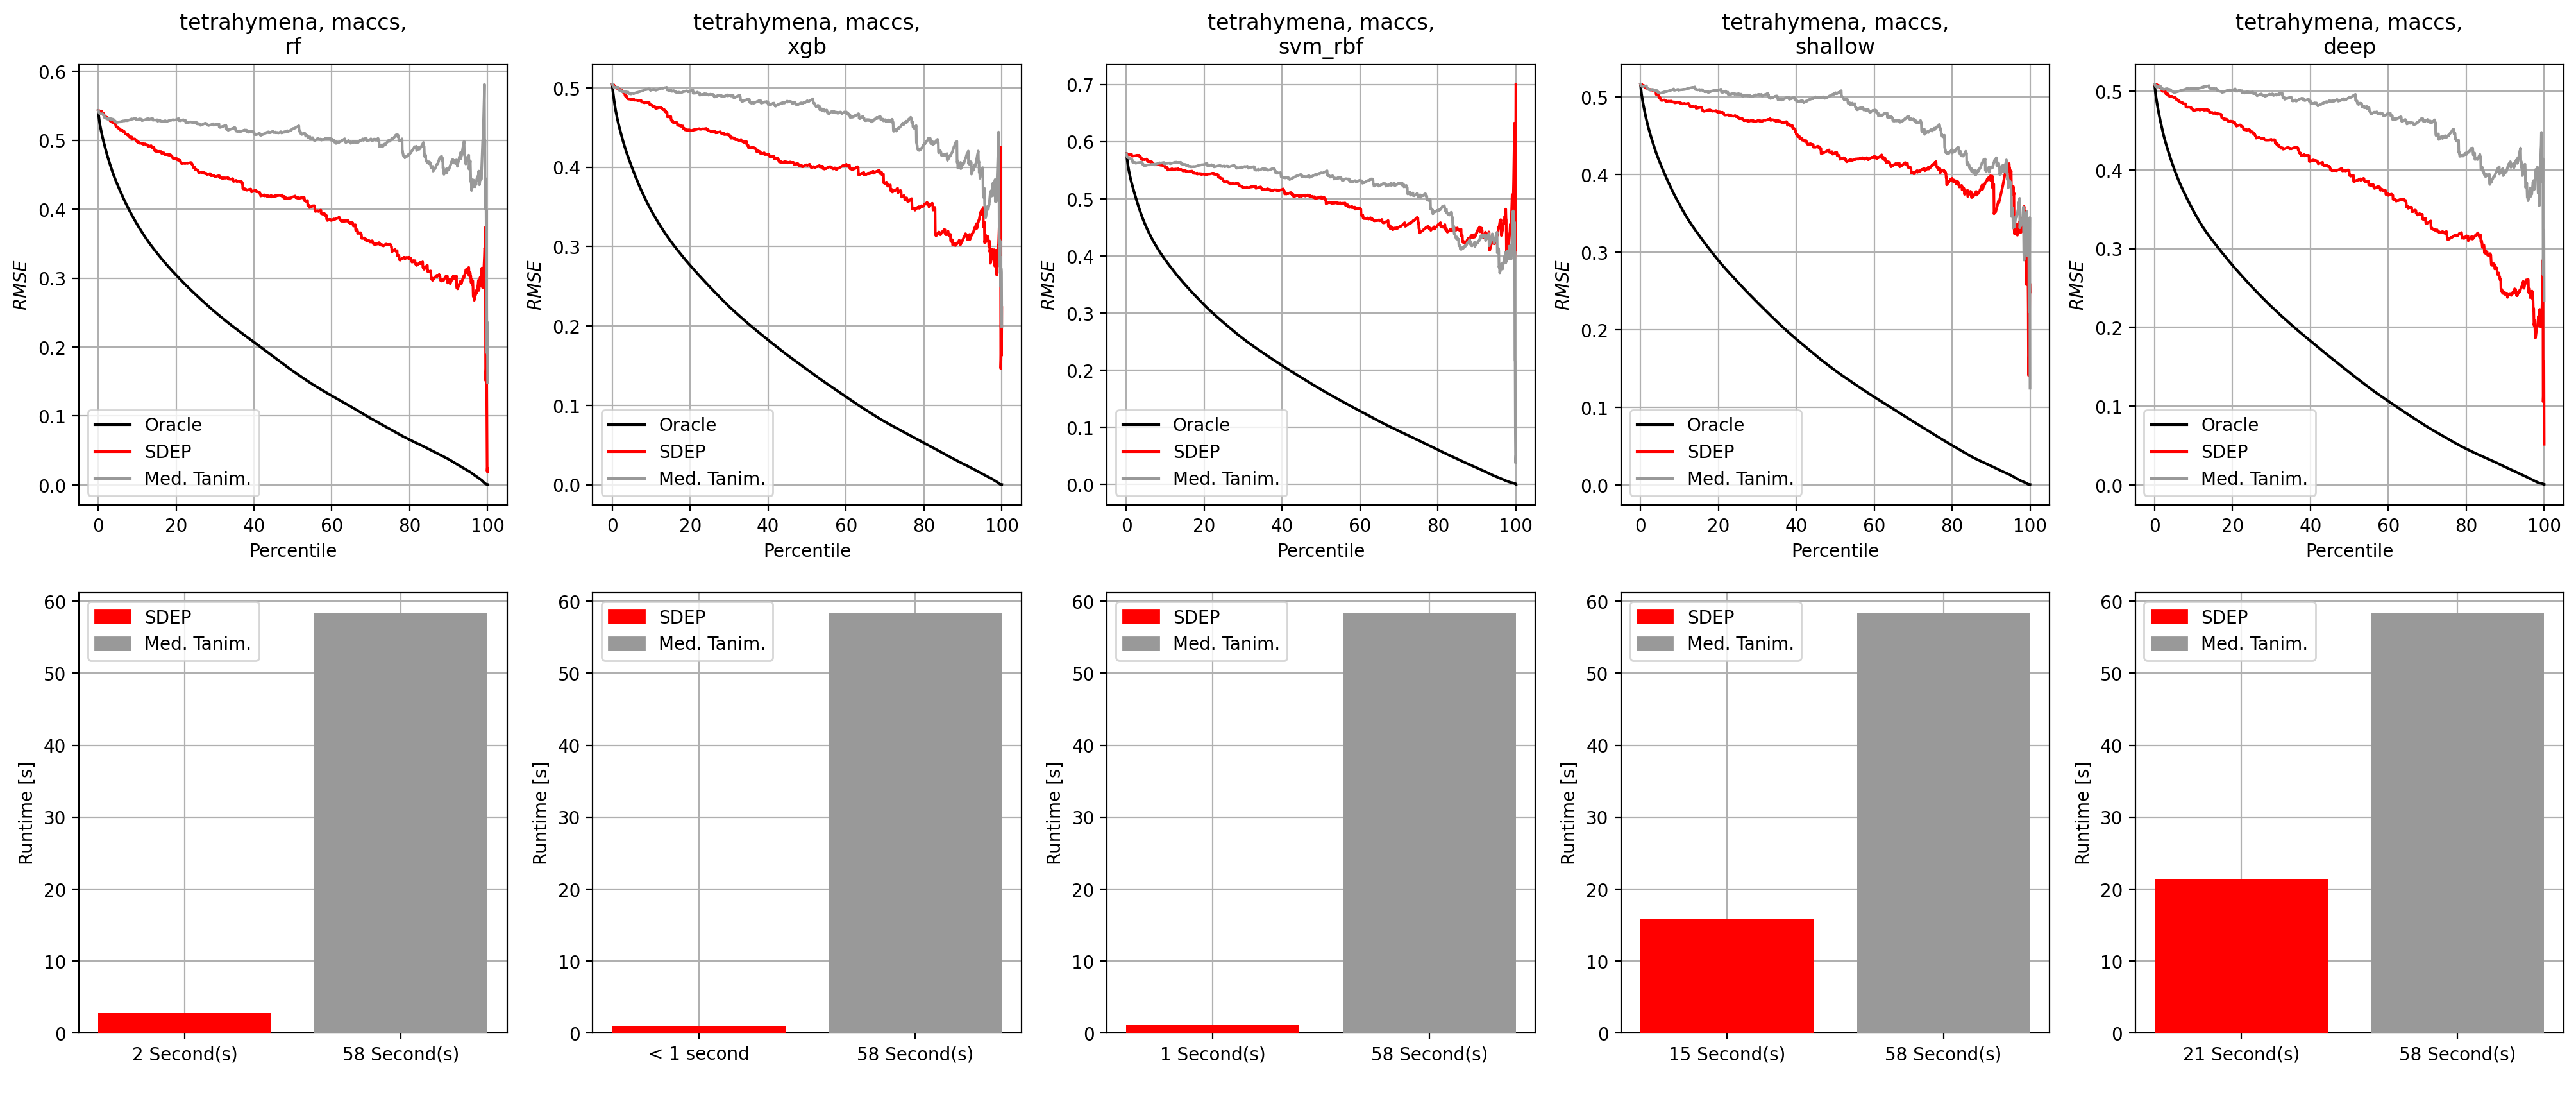

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  1%|          | 1/100 [00:00<00:18,  5.34it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [07:09<00:00,  4.29s/it]


Plotting.


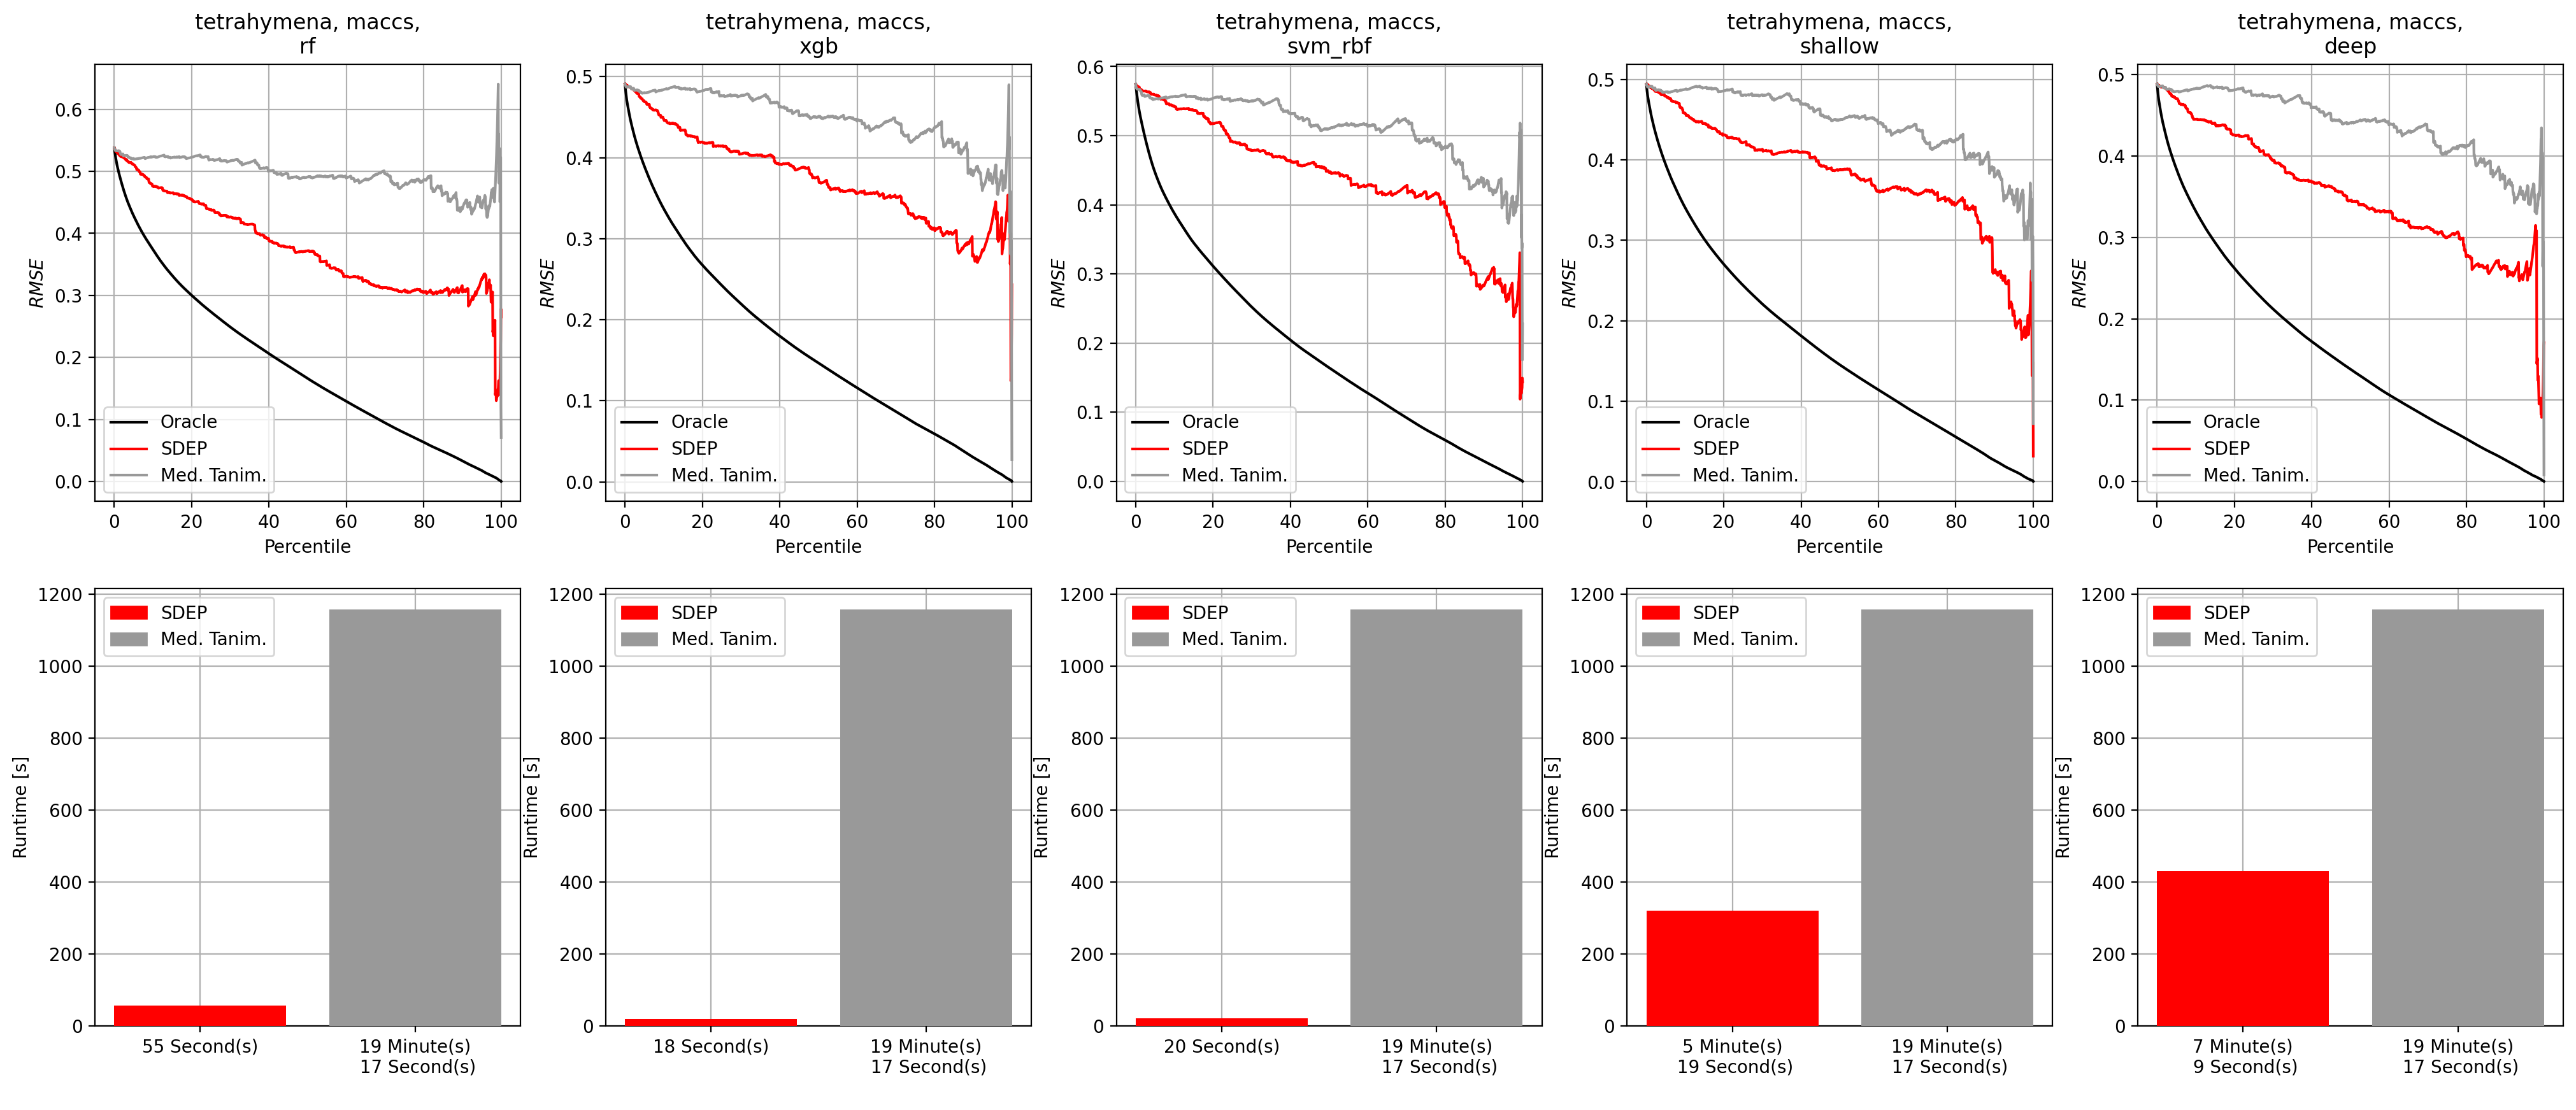

In [13]:
compare_median('tetrahymena', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('tetrahymena', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### Tetrahymena, ECFP, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:25<00:00,  5.03s/it]


Plotting.


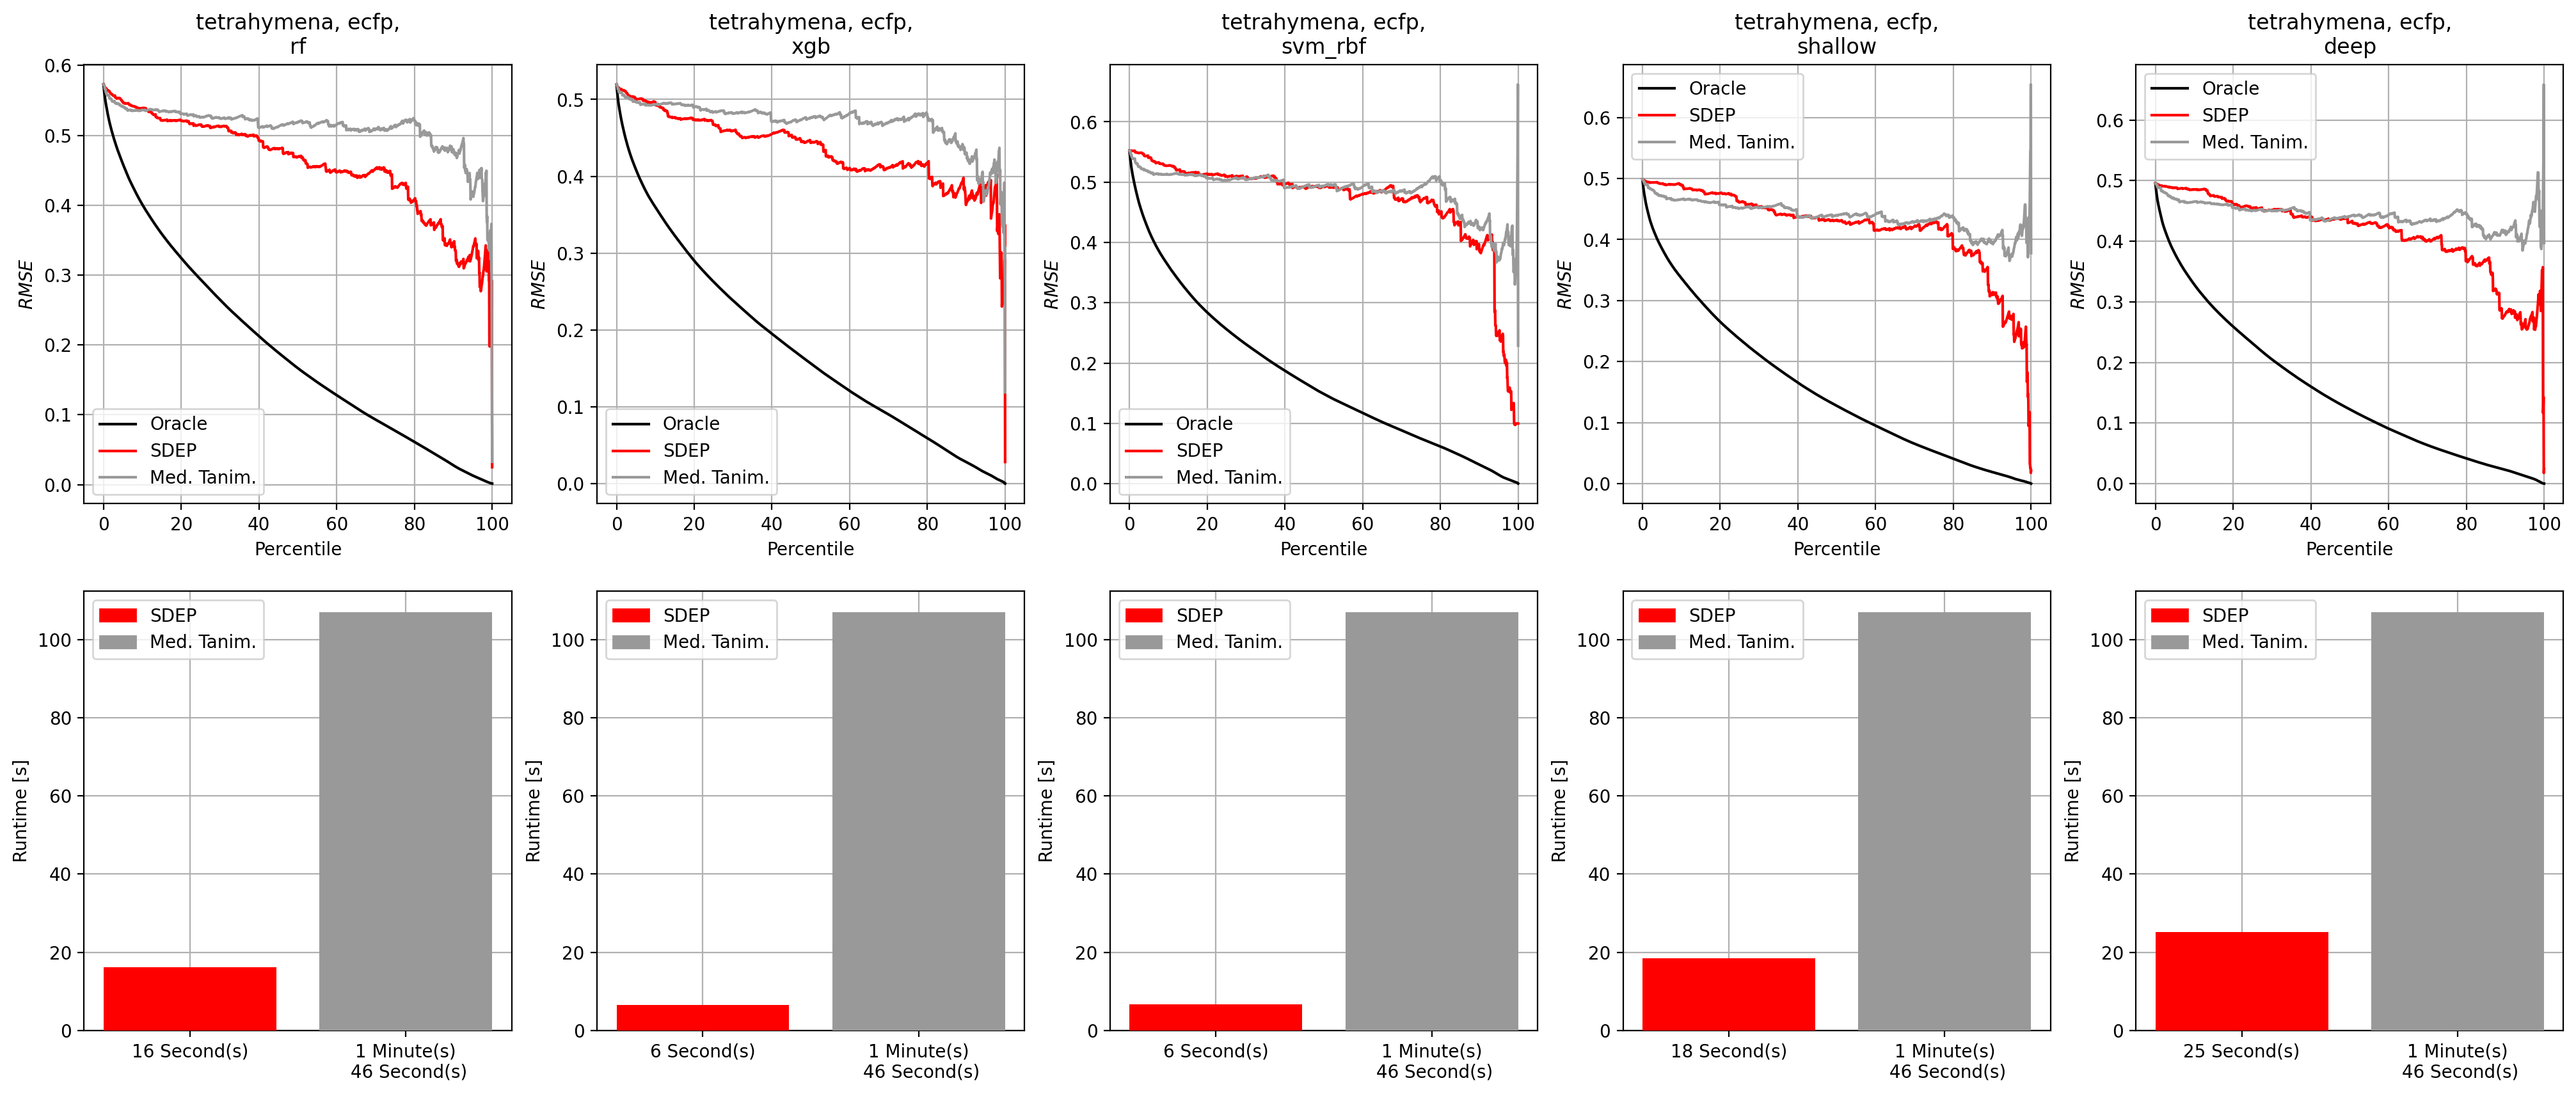

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [08:07<00:00,  4.87s/it]


Plotting.


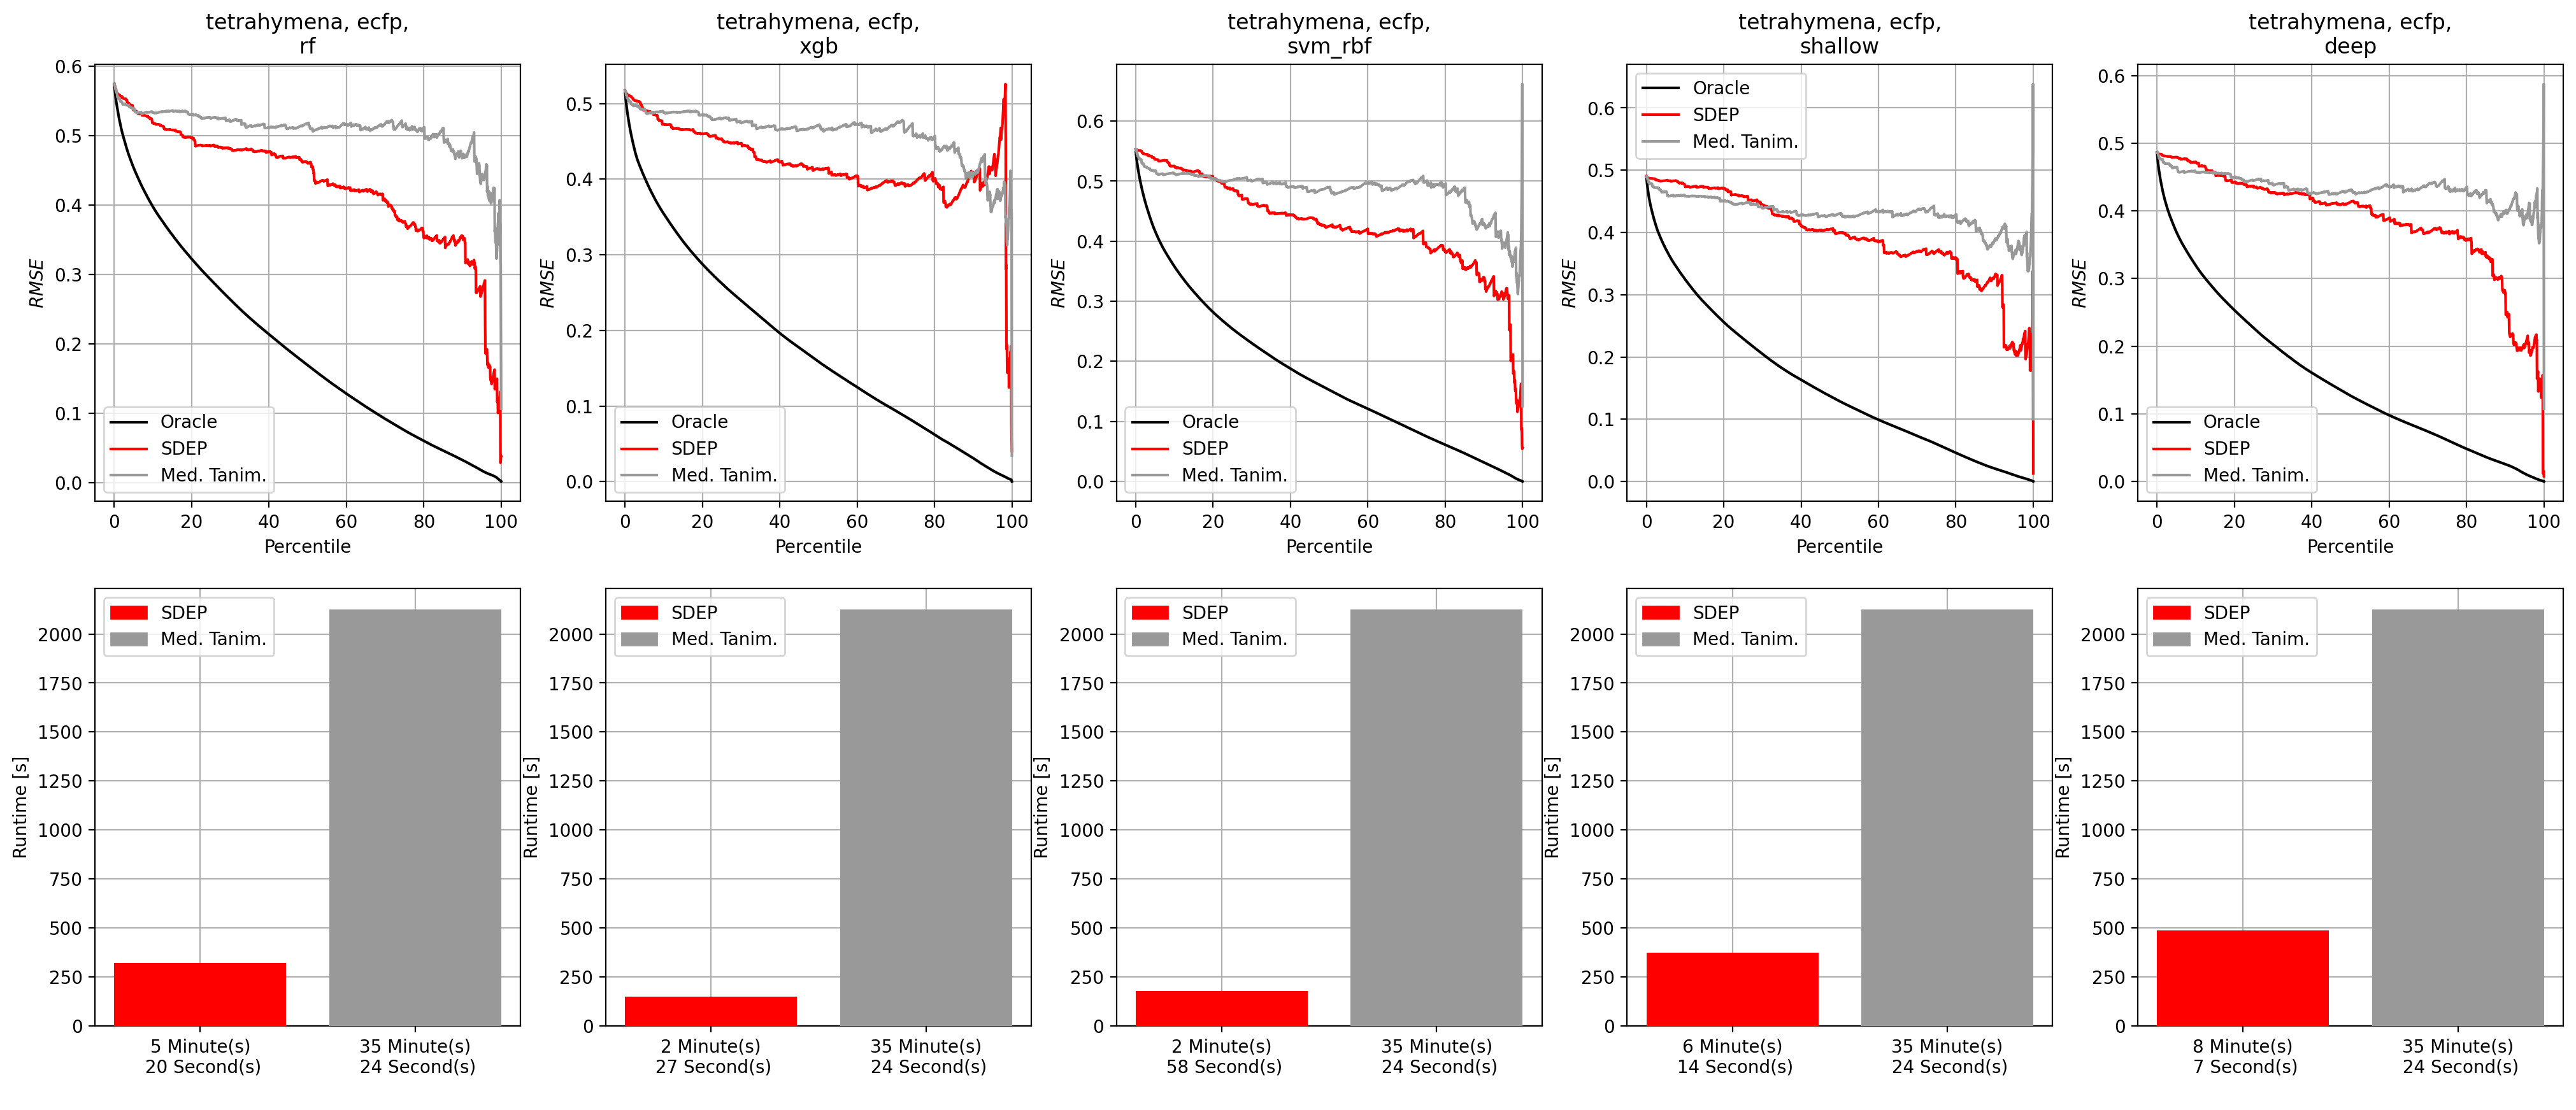

In [14]:
compare_median('tetrahymena', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('tetrahymena', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### FreeSolv, MACCS, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

At xgb.


 40%|████      | 2/5 [00:00<00:00, 13.93it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Plotting.


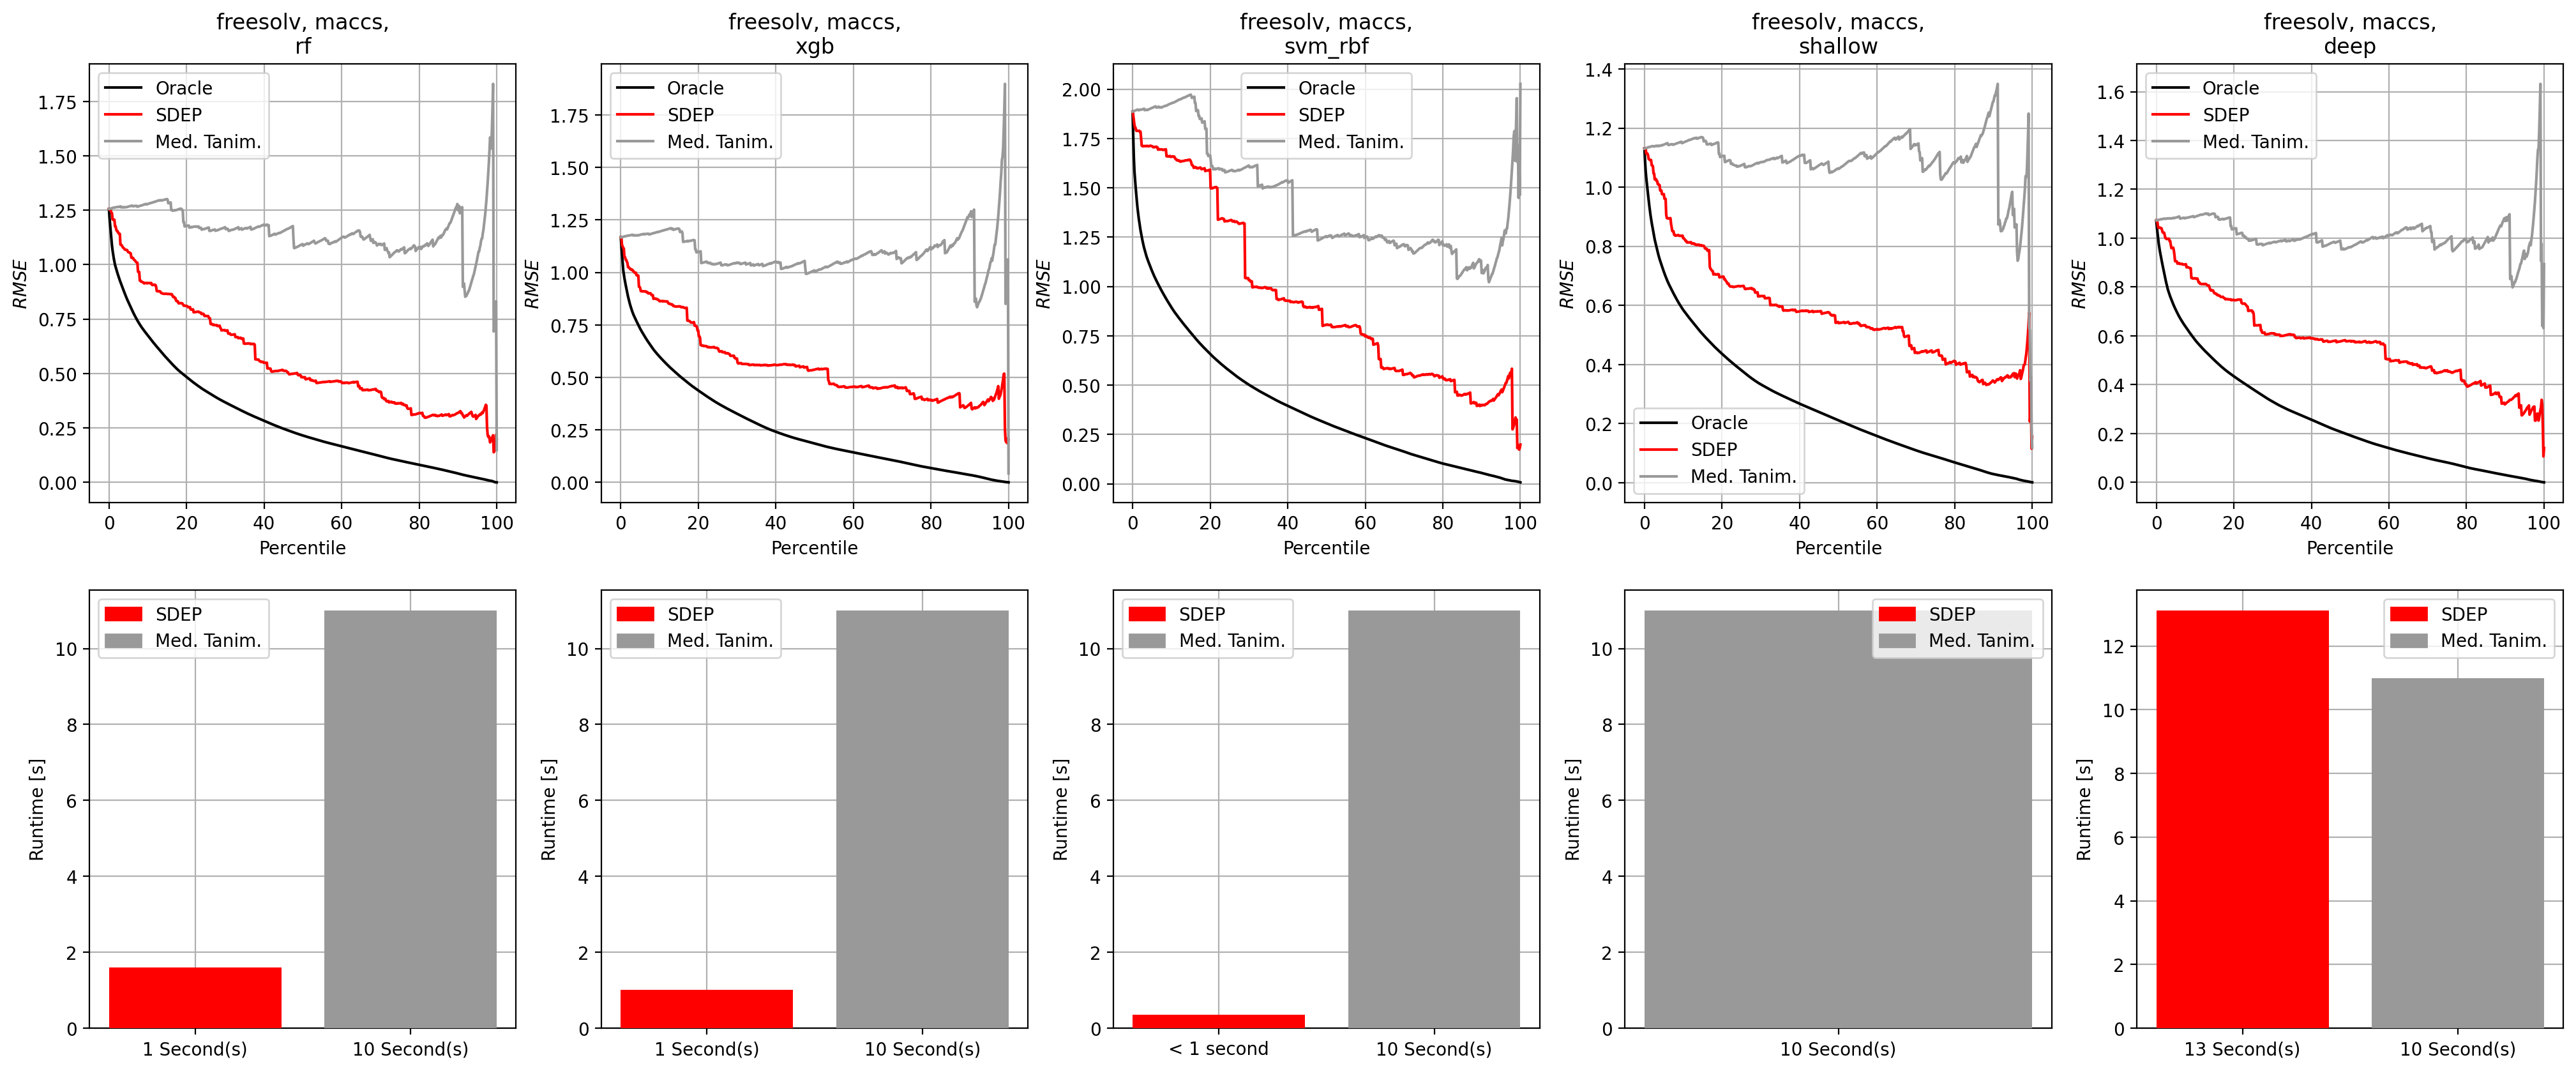

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  1%|          | 1/100 [00:00<00:15,  6.48it/s]

At xgb.


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


Plotting.


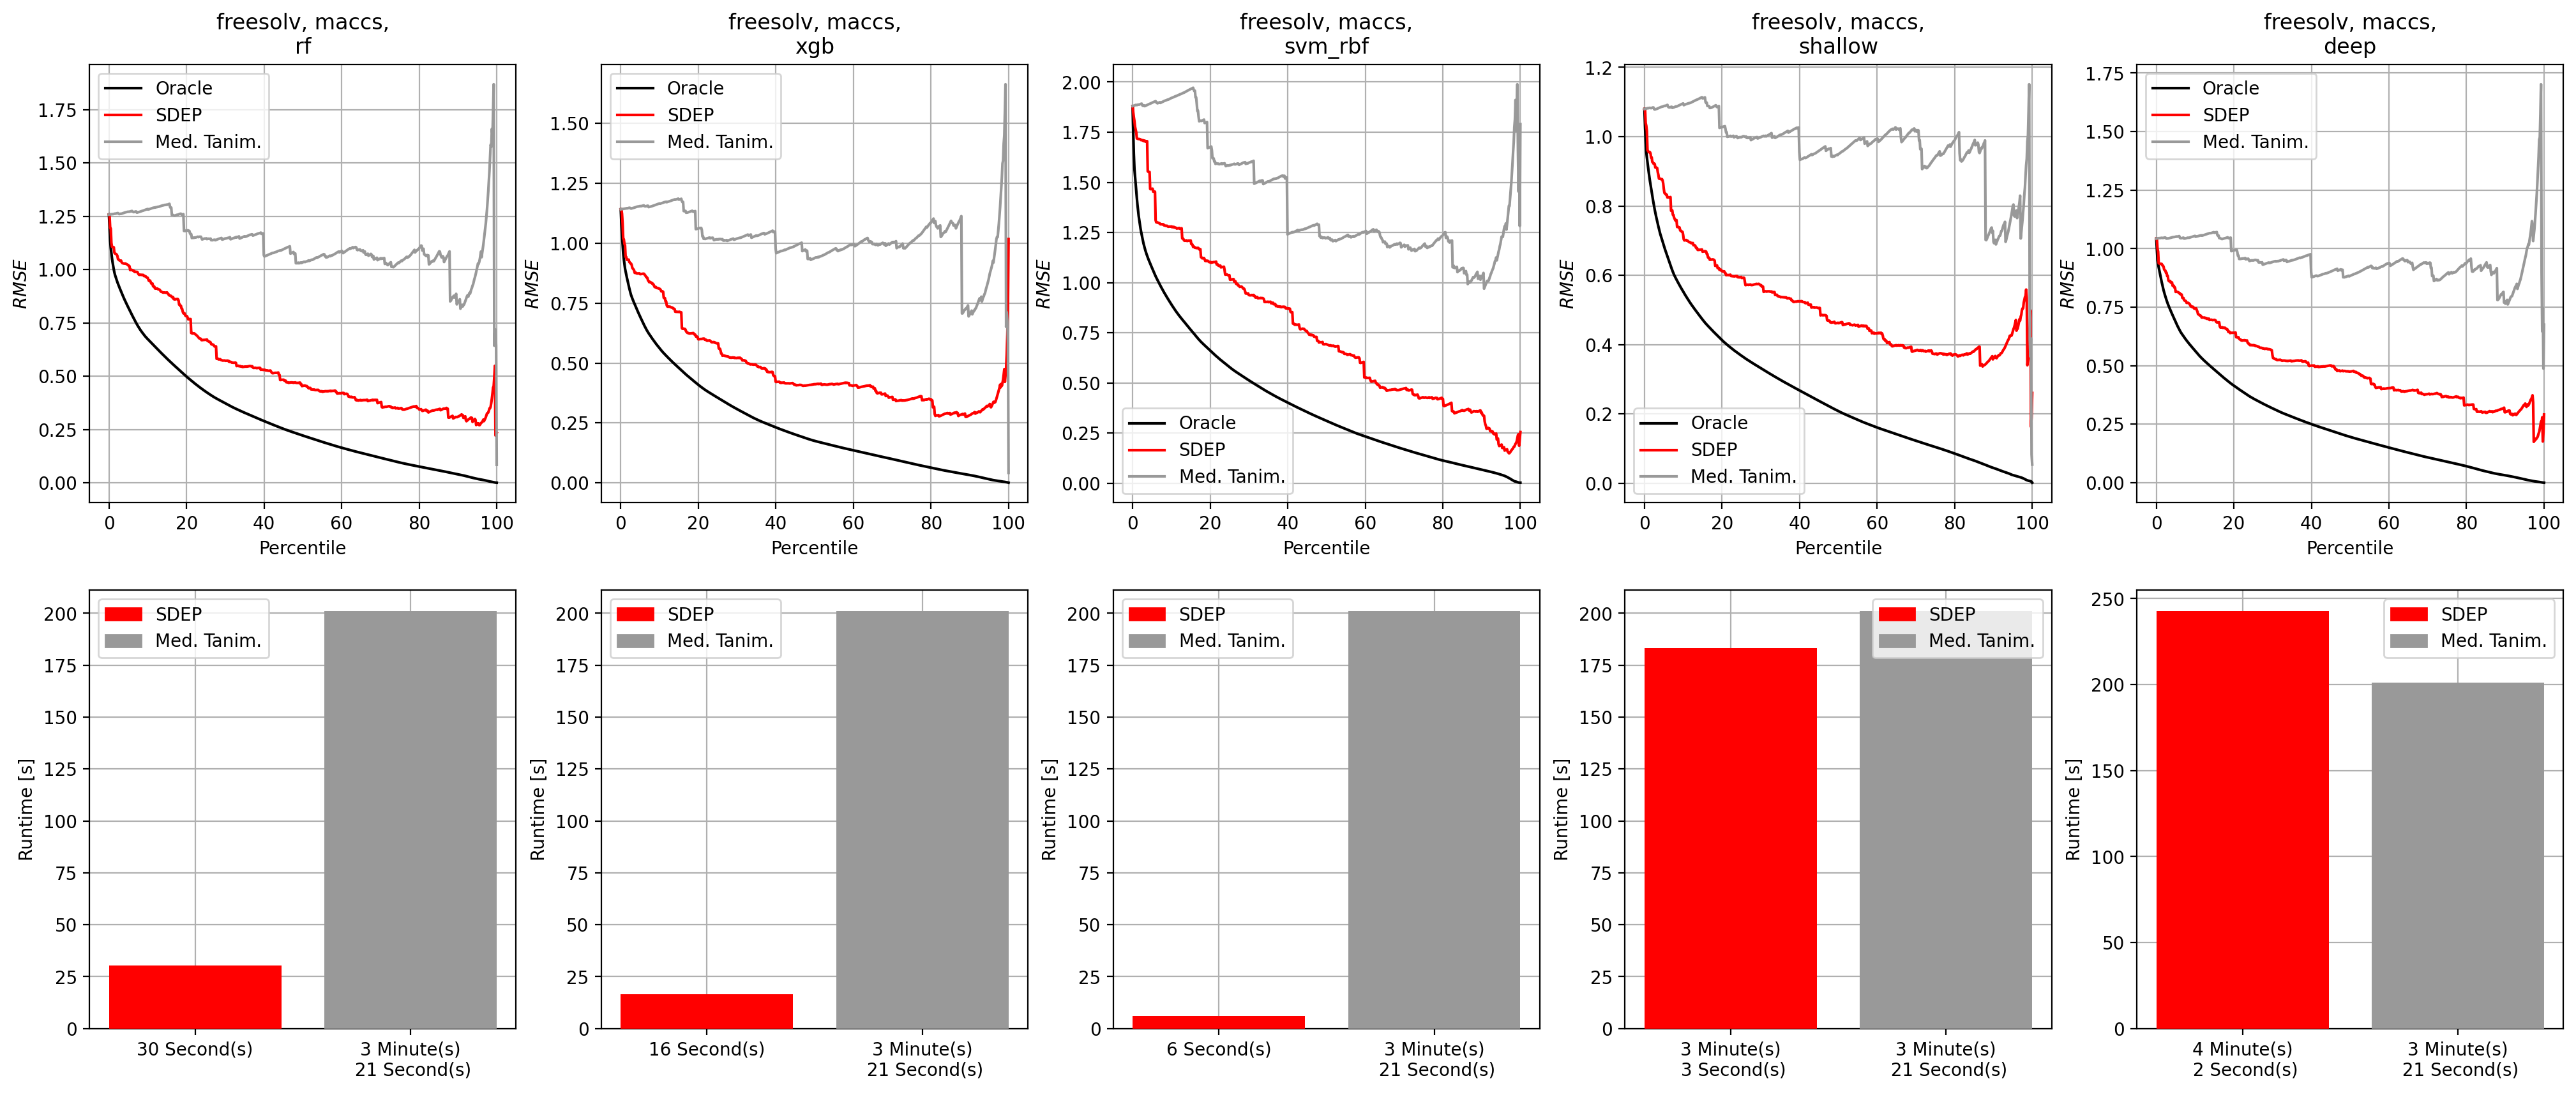

In [15]:
compare_median('freesolv', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('freesolv', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### FreeSolv, ECFP, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Plotting.


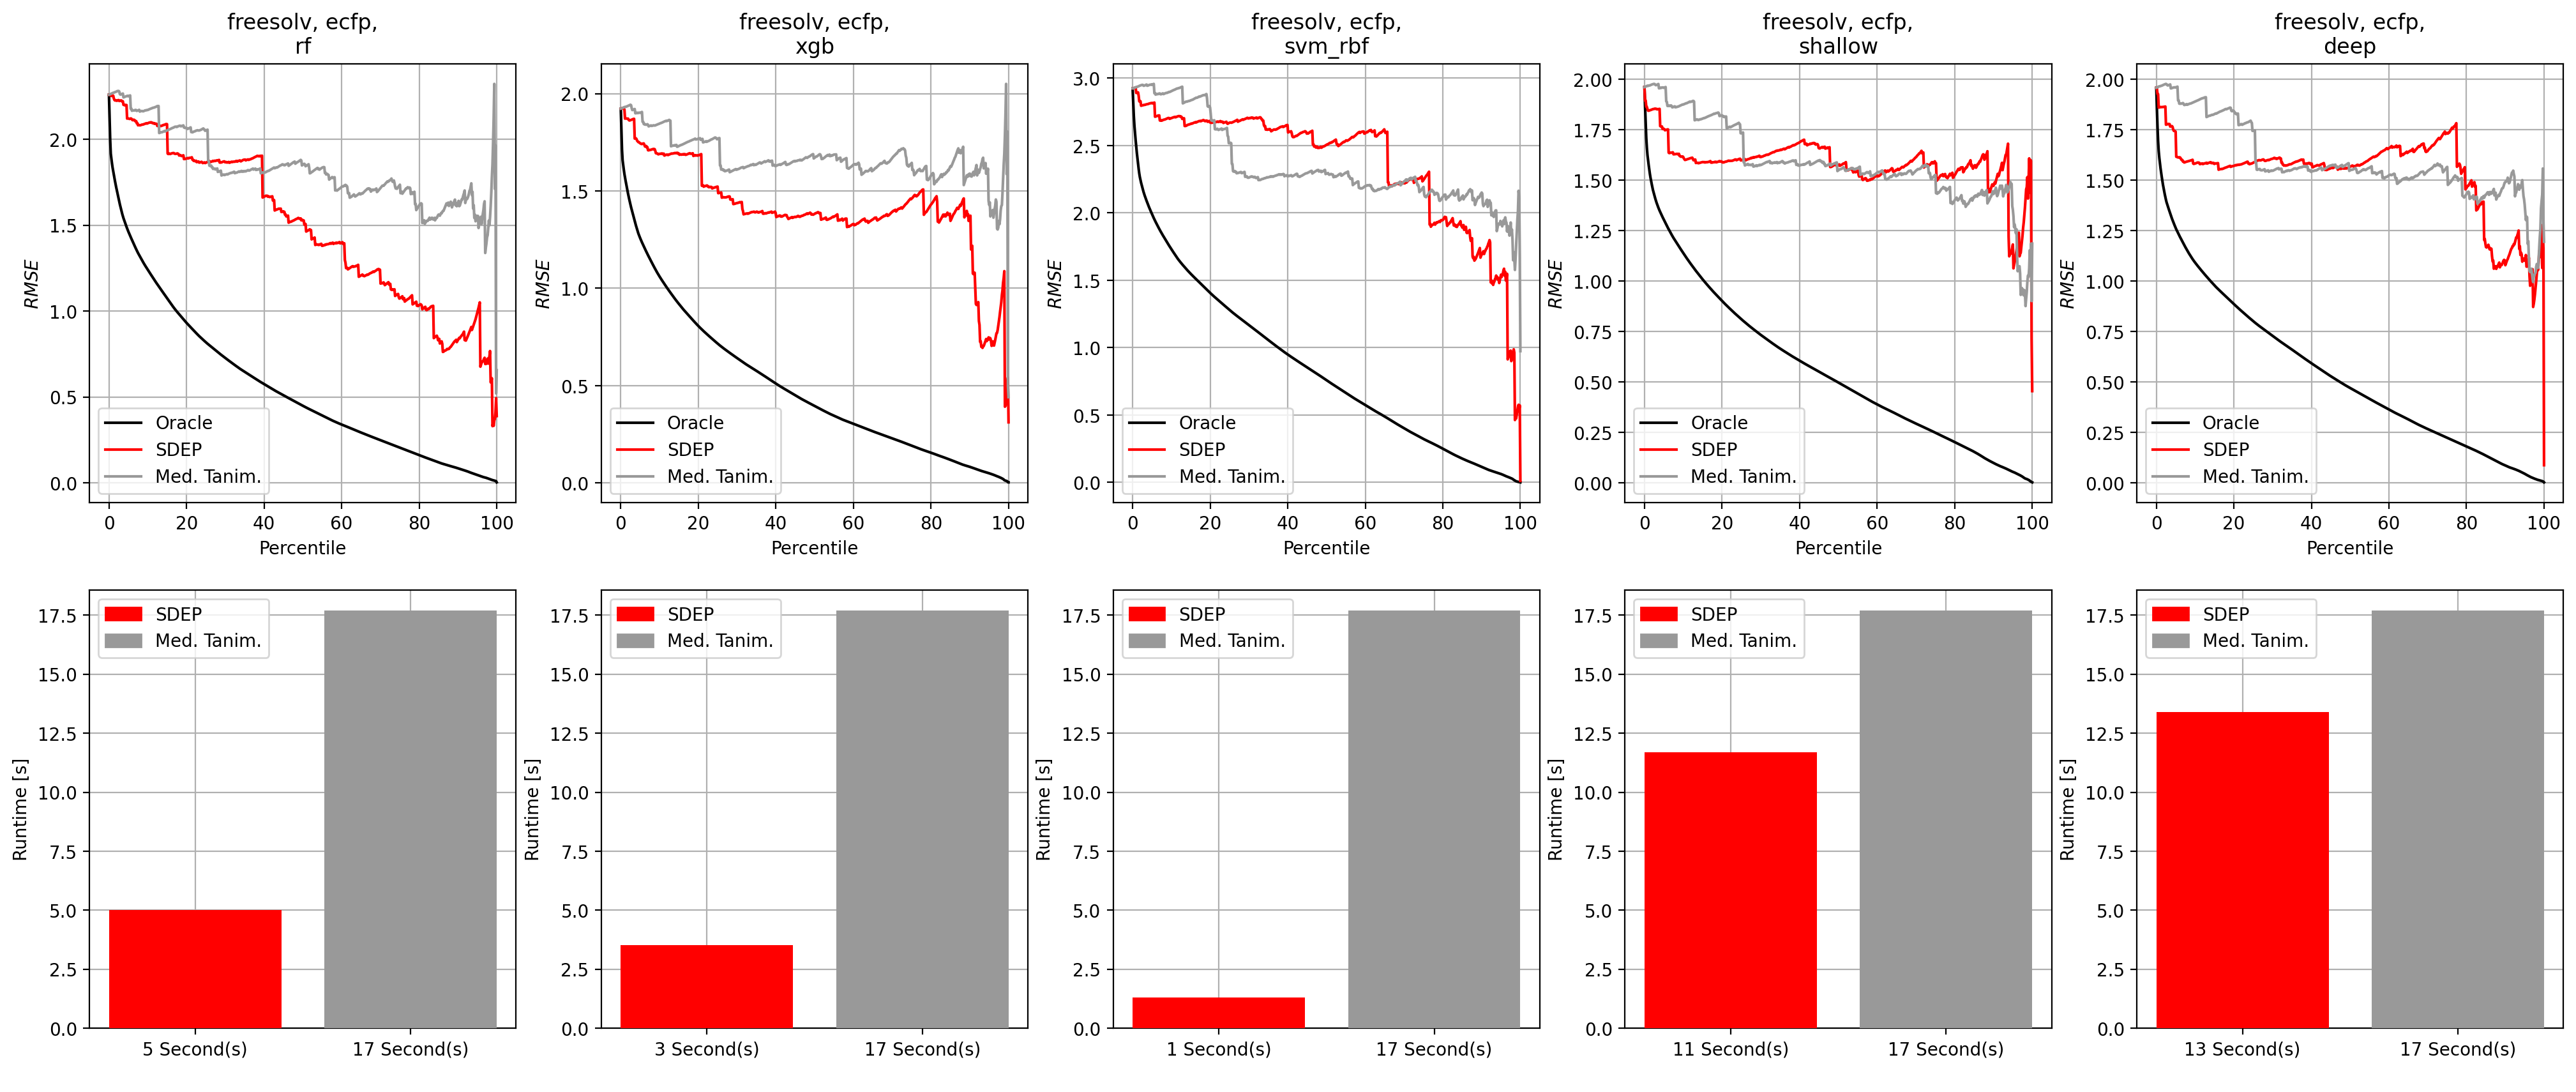

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [04:21<00:00,  2.62s/it]


Plotting.


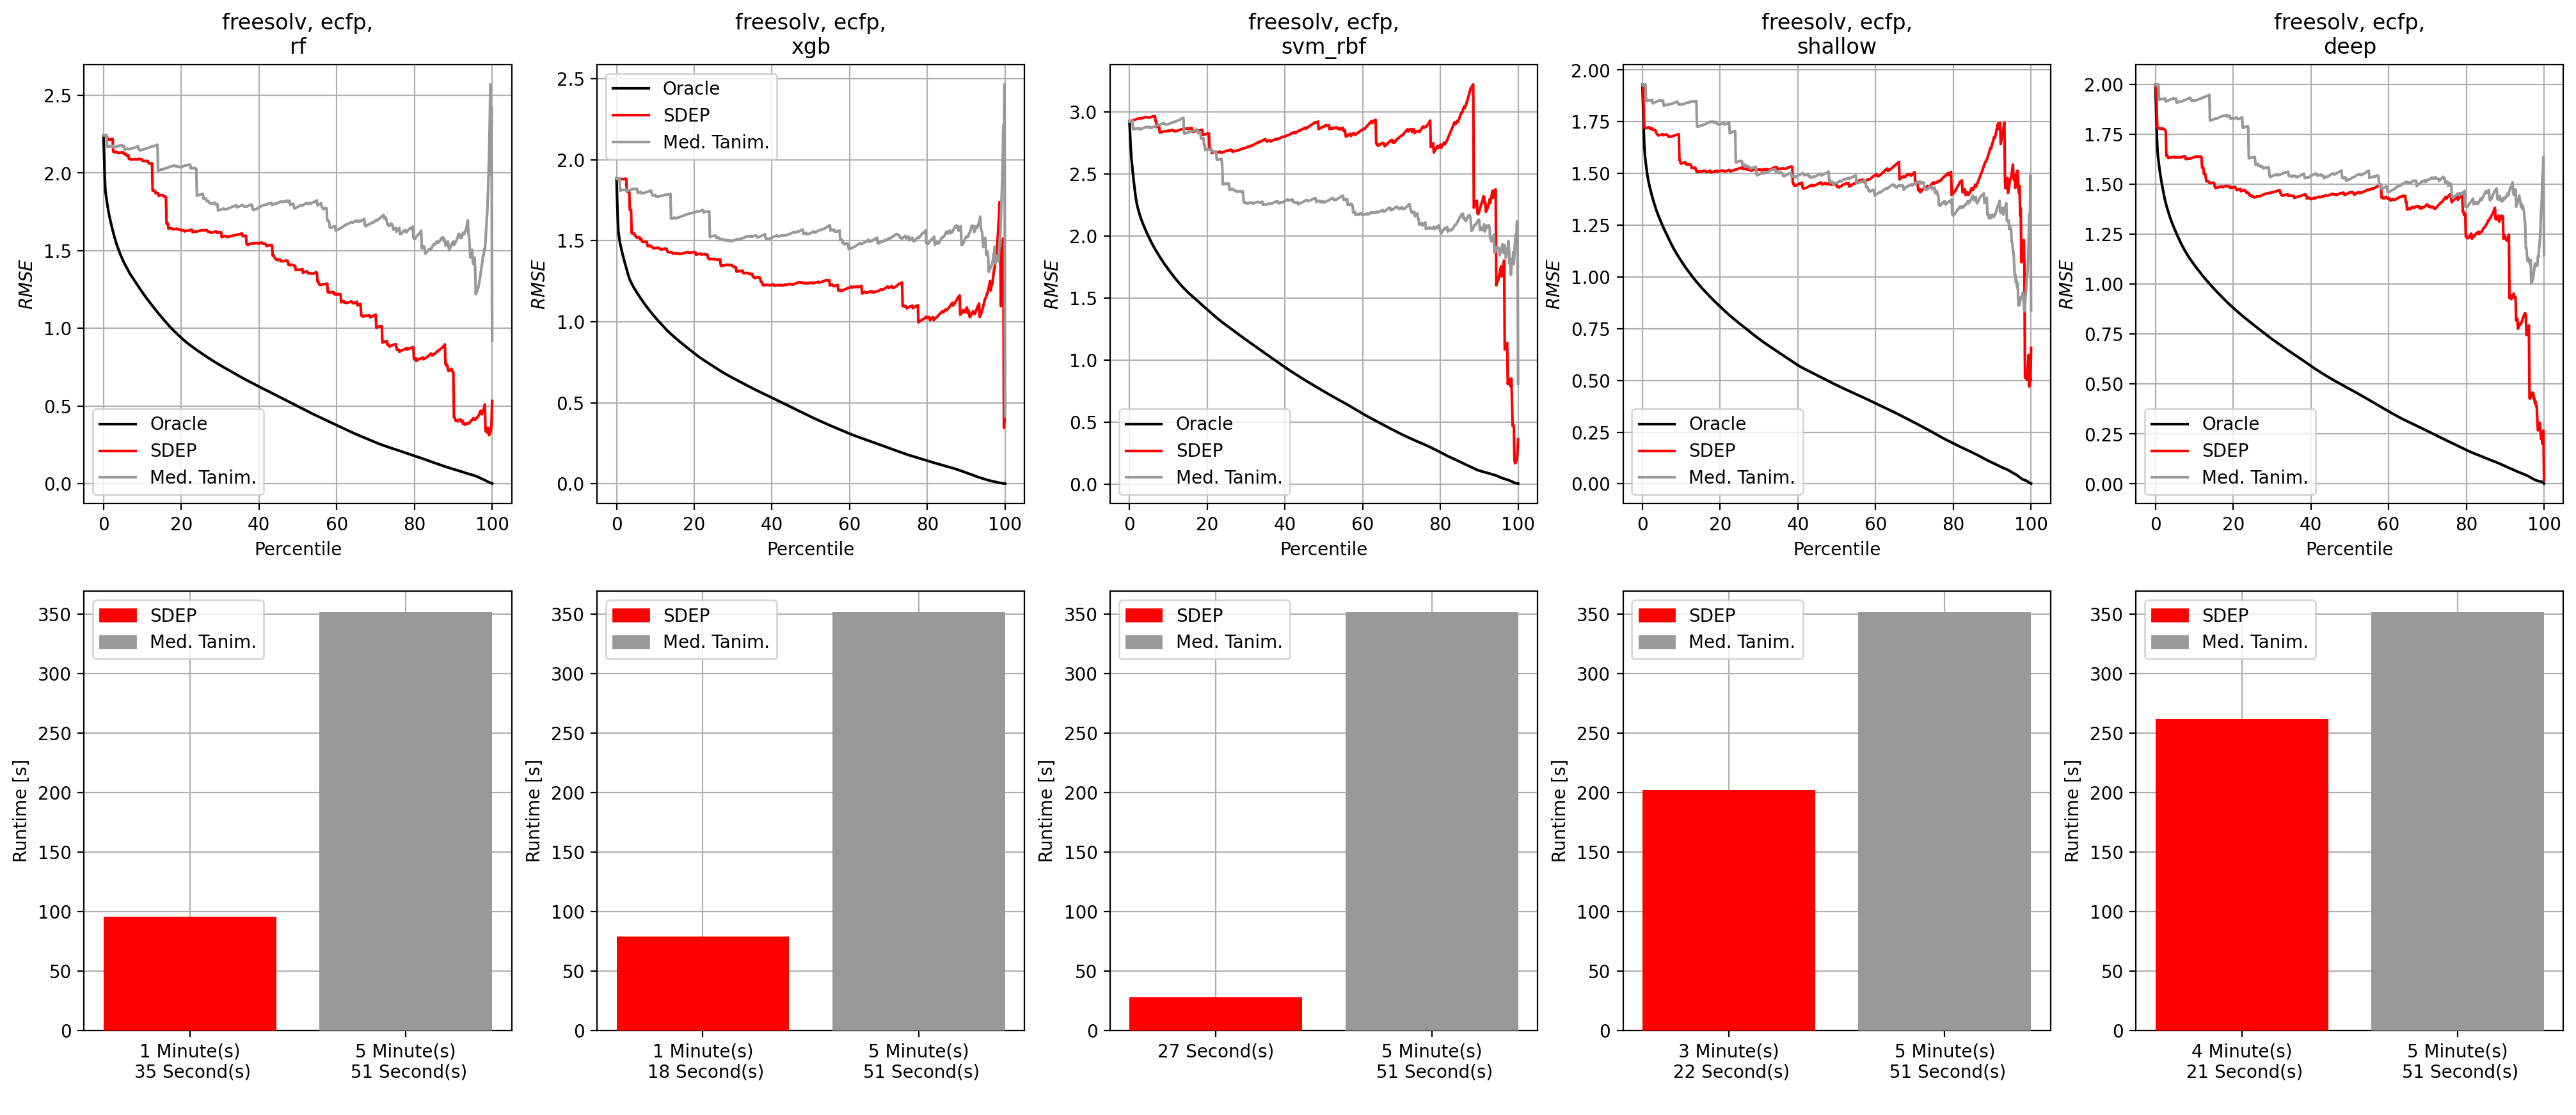

In [16]:
compare_median('freesolv', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('freesolv', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### IL4, MACCS, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


 20%|██        | 1/5 [00:00<00:00,  7.52it/s]

At xgb.


 60%|██████    | 3/5 [00:00<00:00, 23.70it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Plotting.


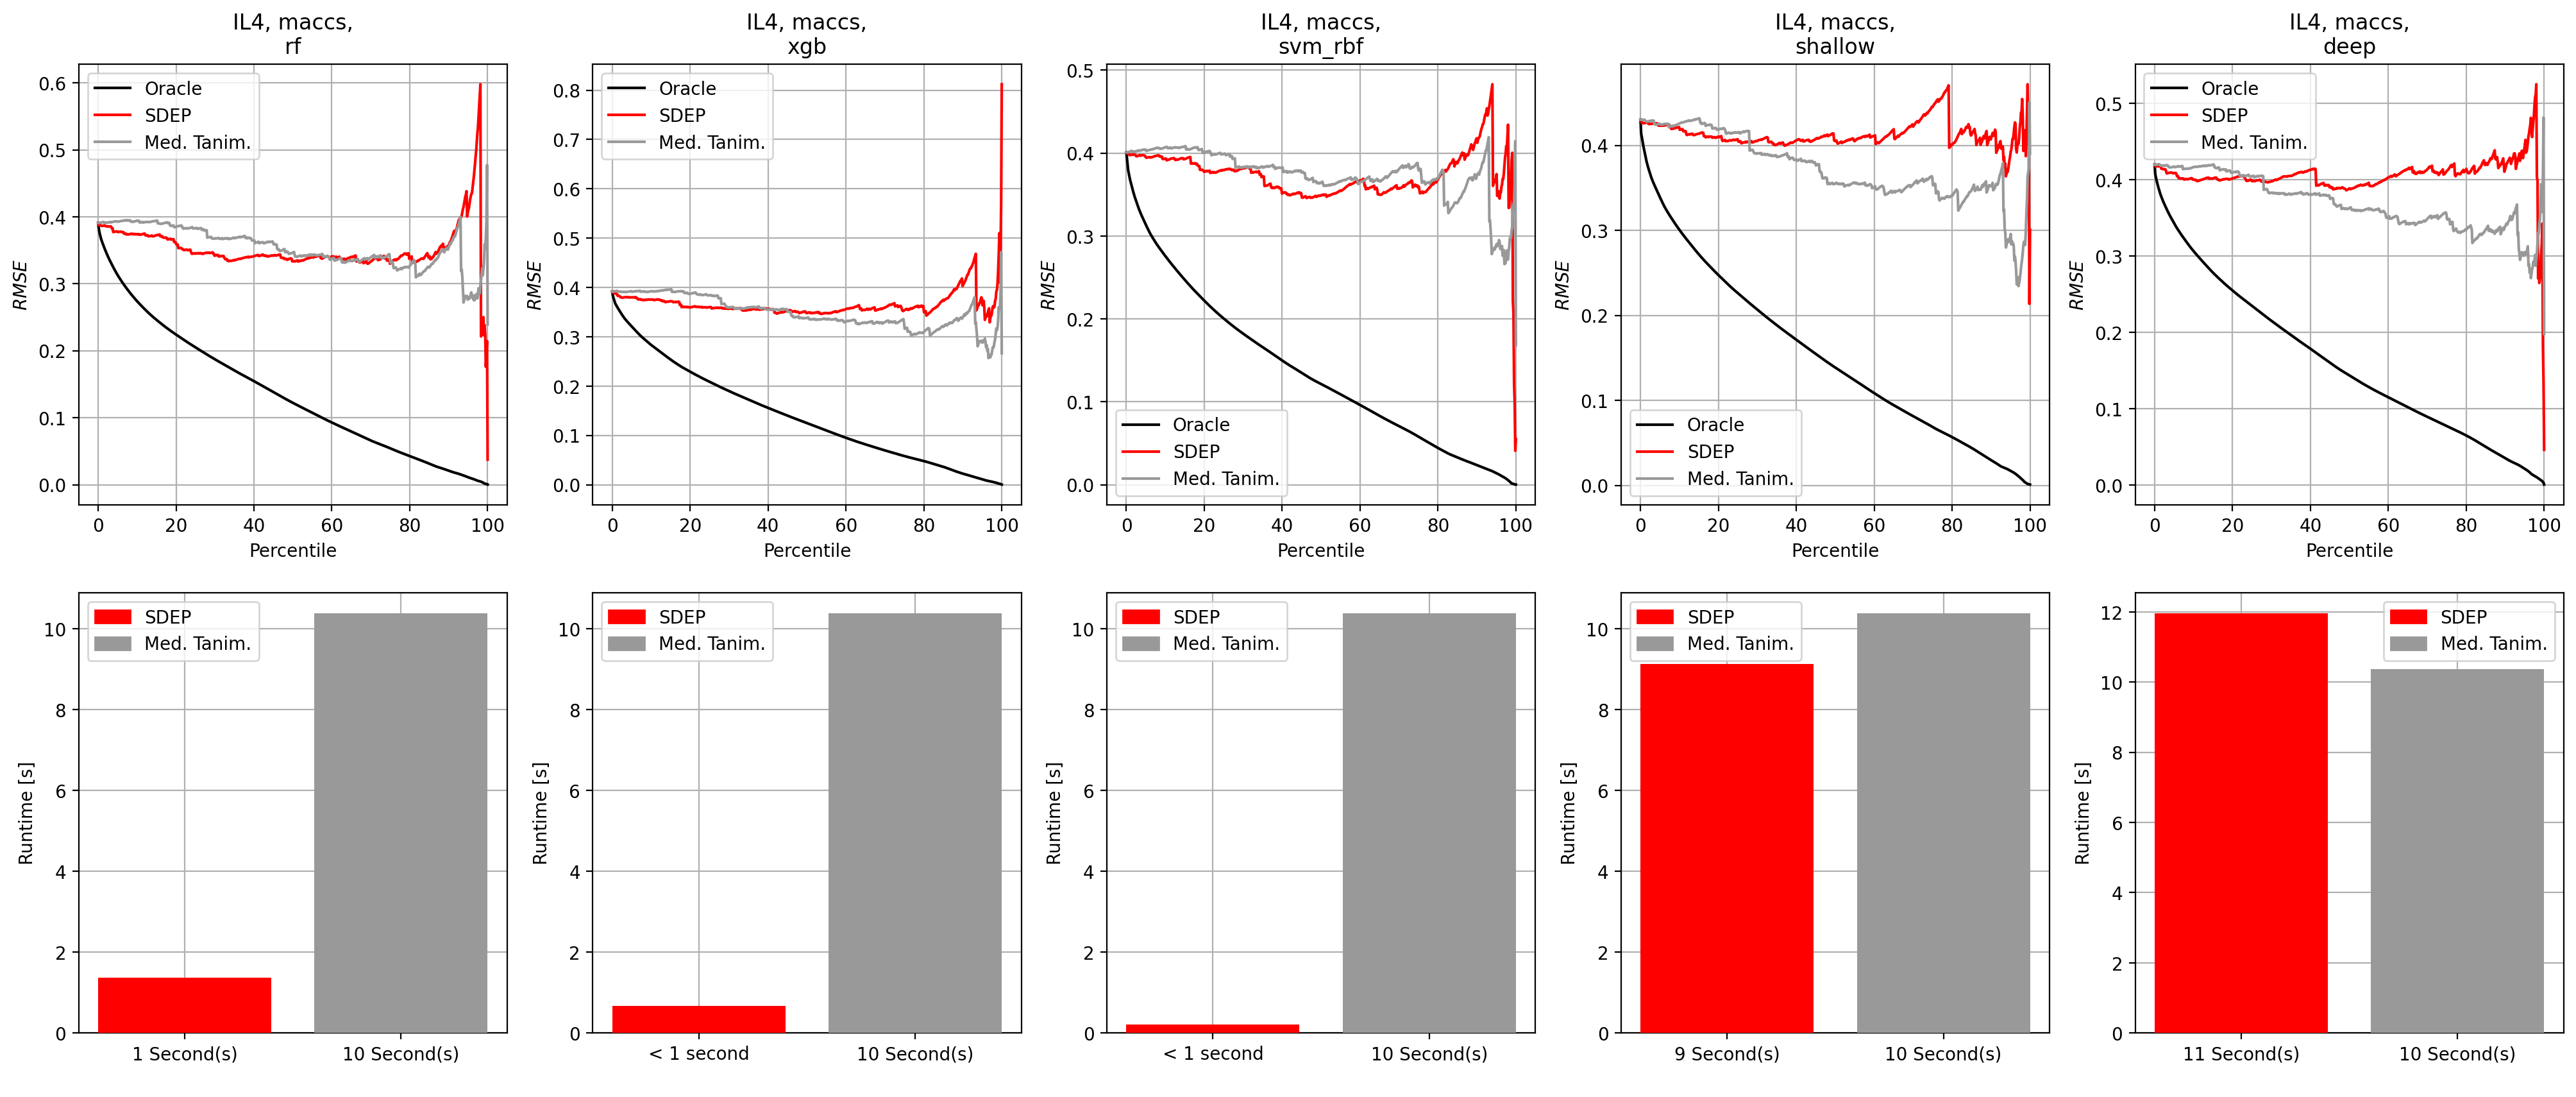

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  1%|          | 1/100 [00:00<00:12,  7.88it/s]

At xgb.


  3%|▎         | 3/100 [00:00<00:04, 23.26it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


Plotting.


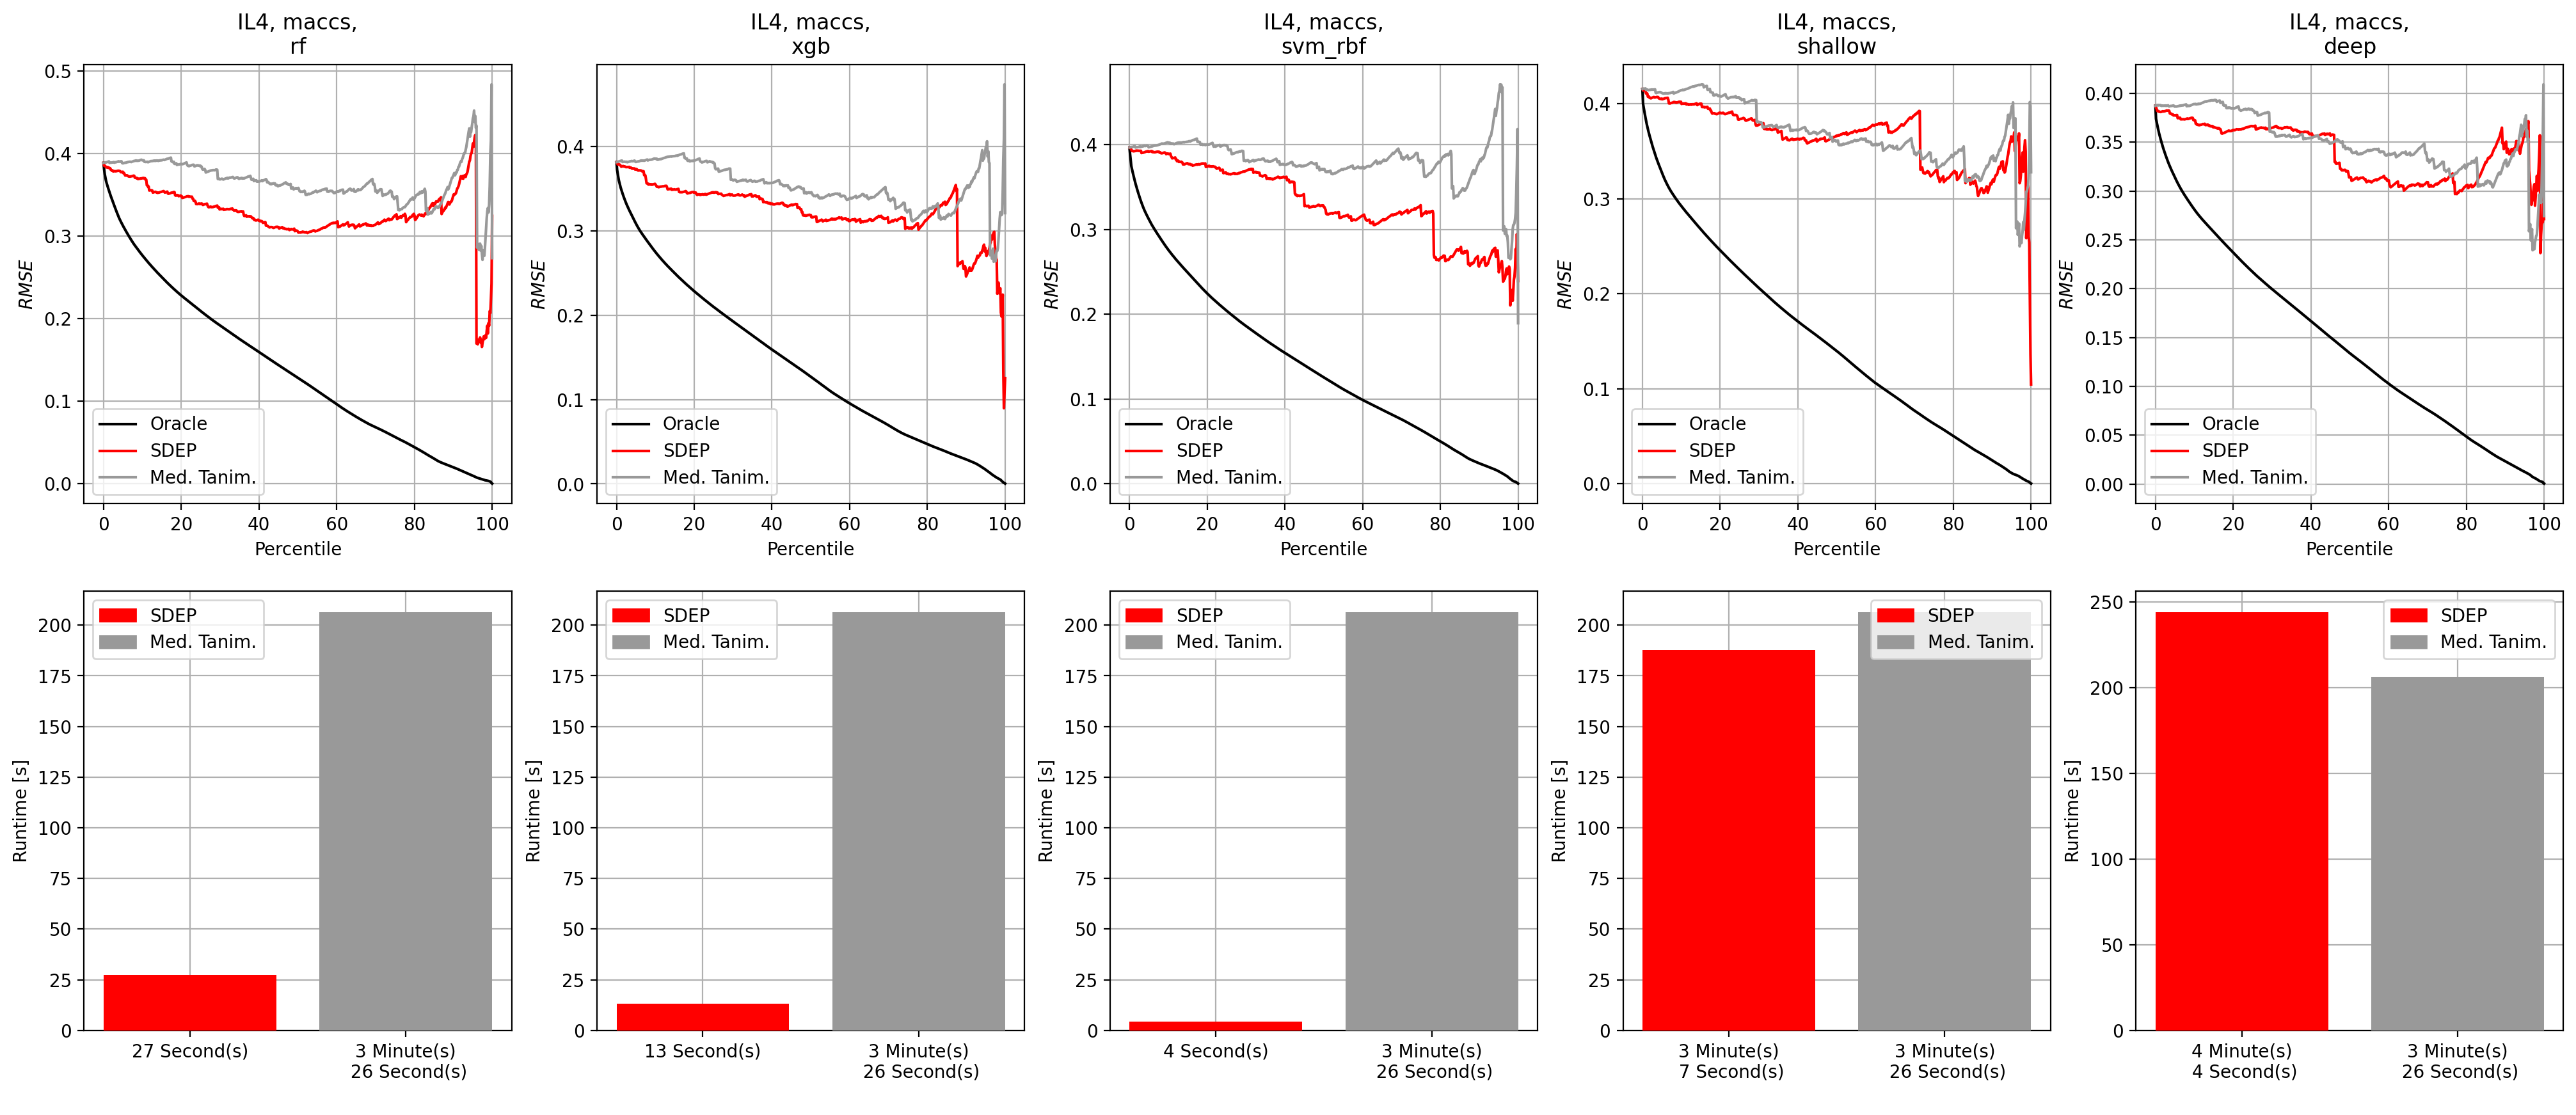

In [17]:
compare_median('IL4', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('IL4', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### IL4, ECFP, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Plotting.


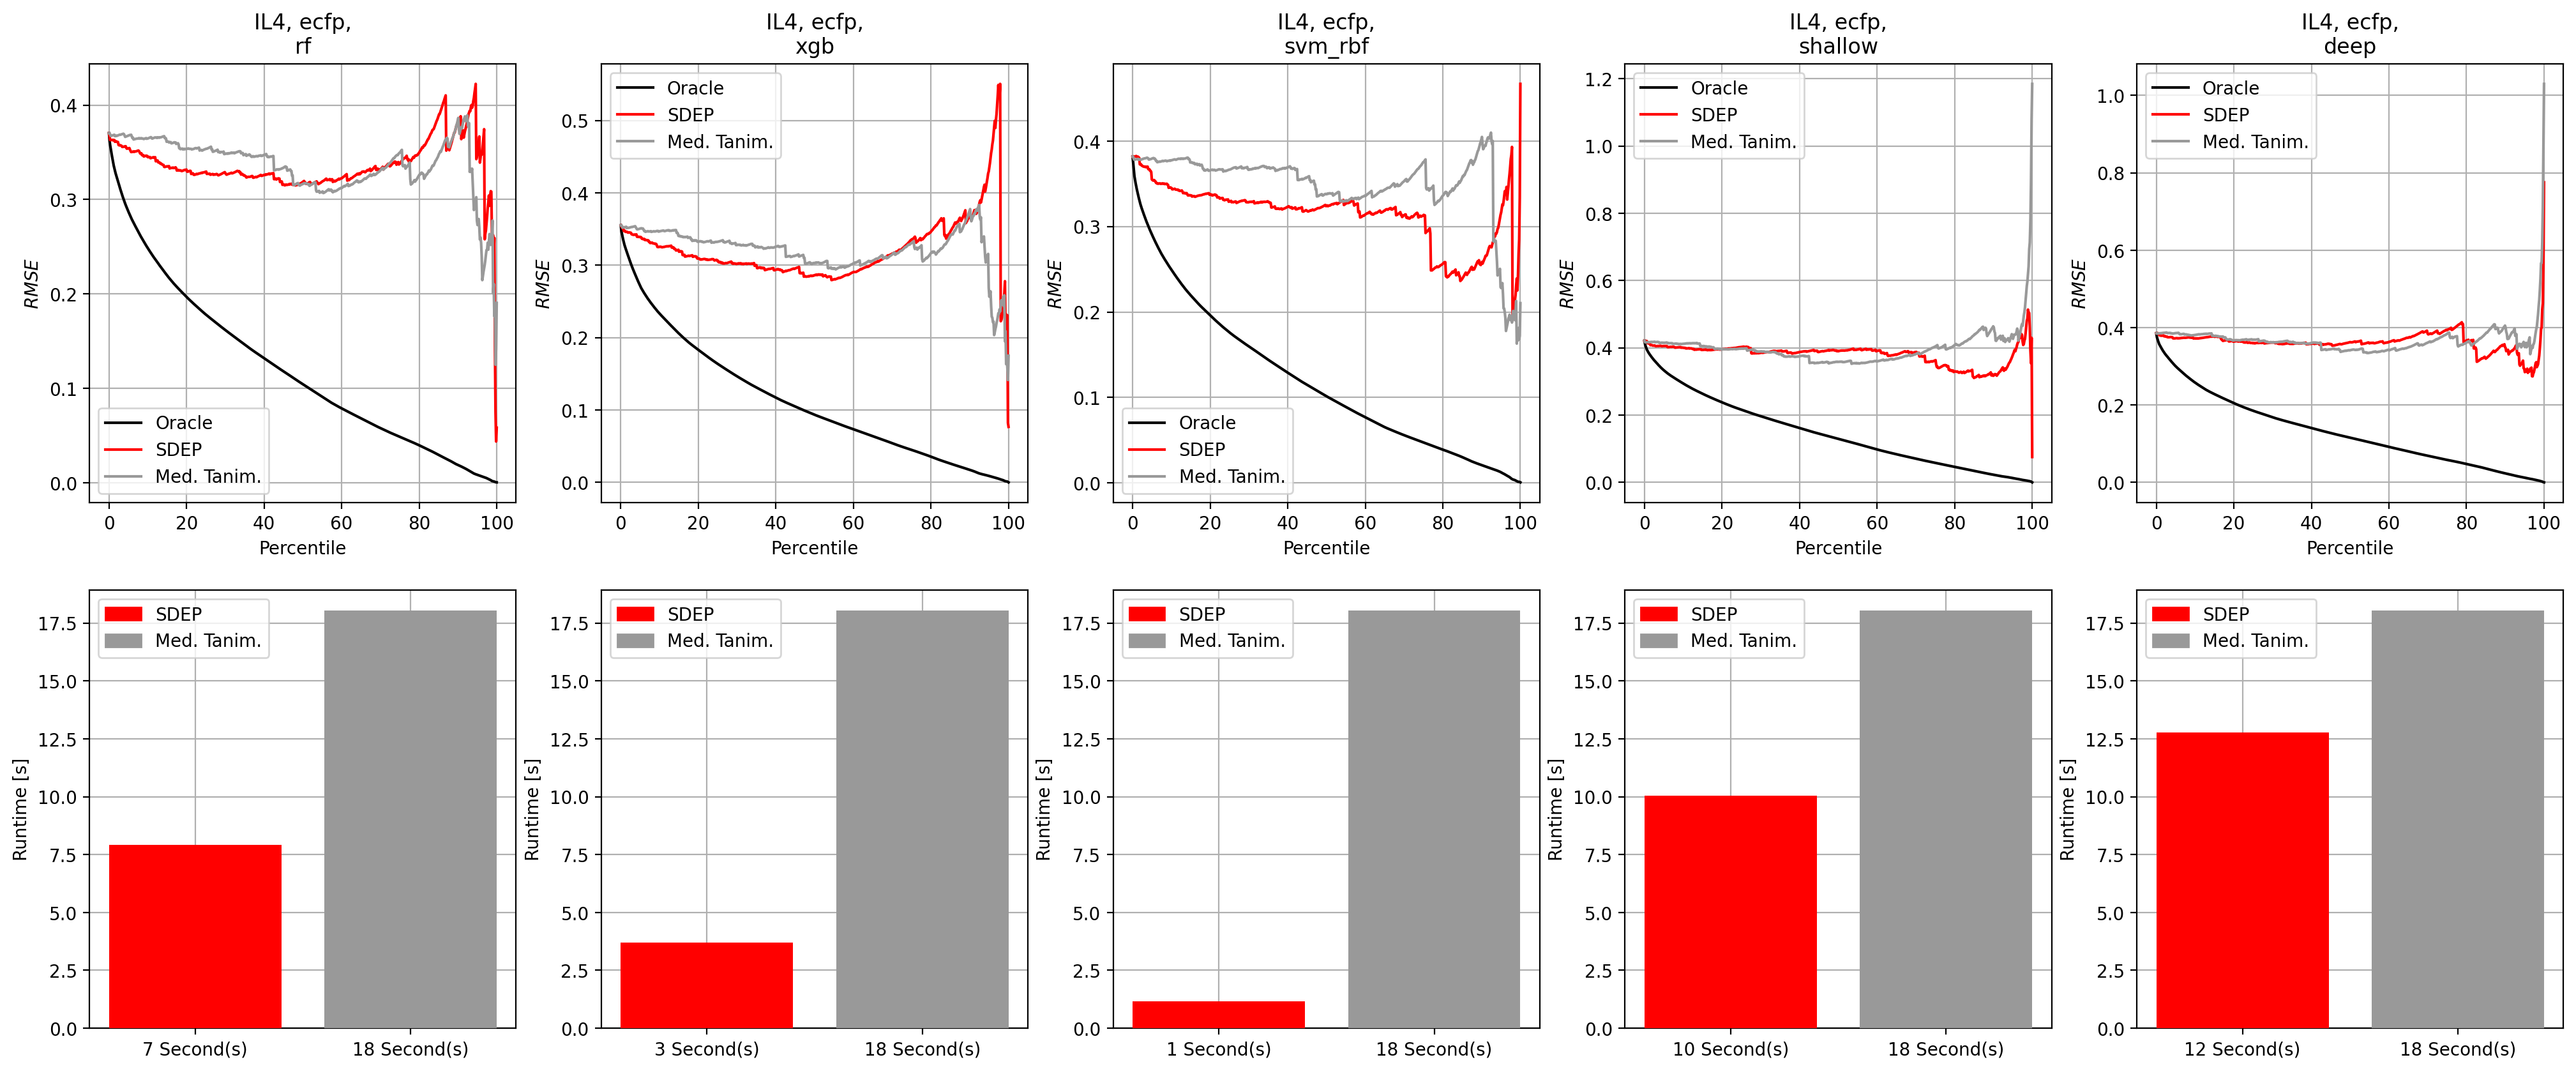

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


Plotting.


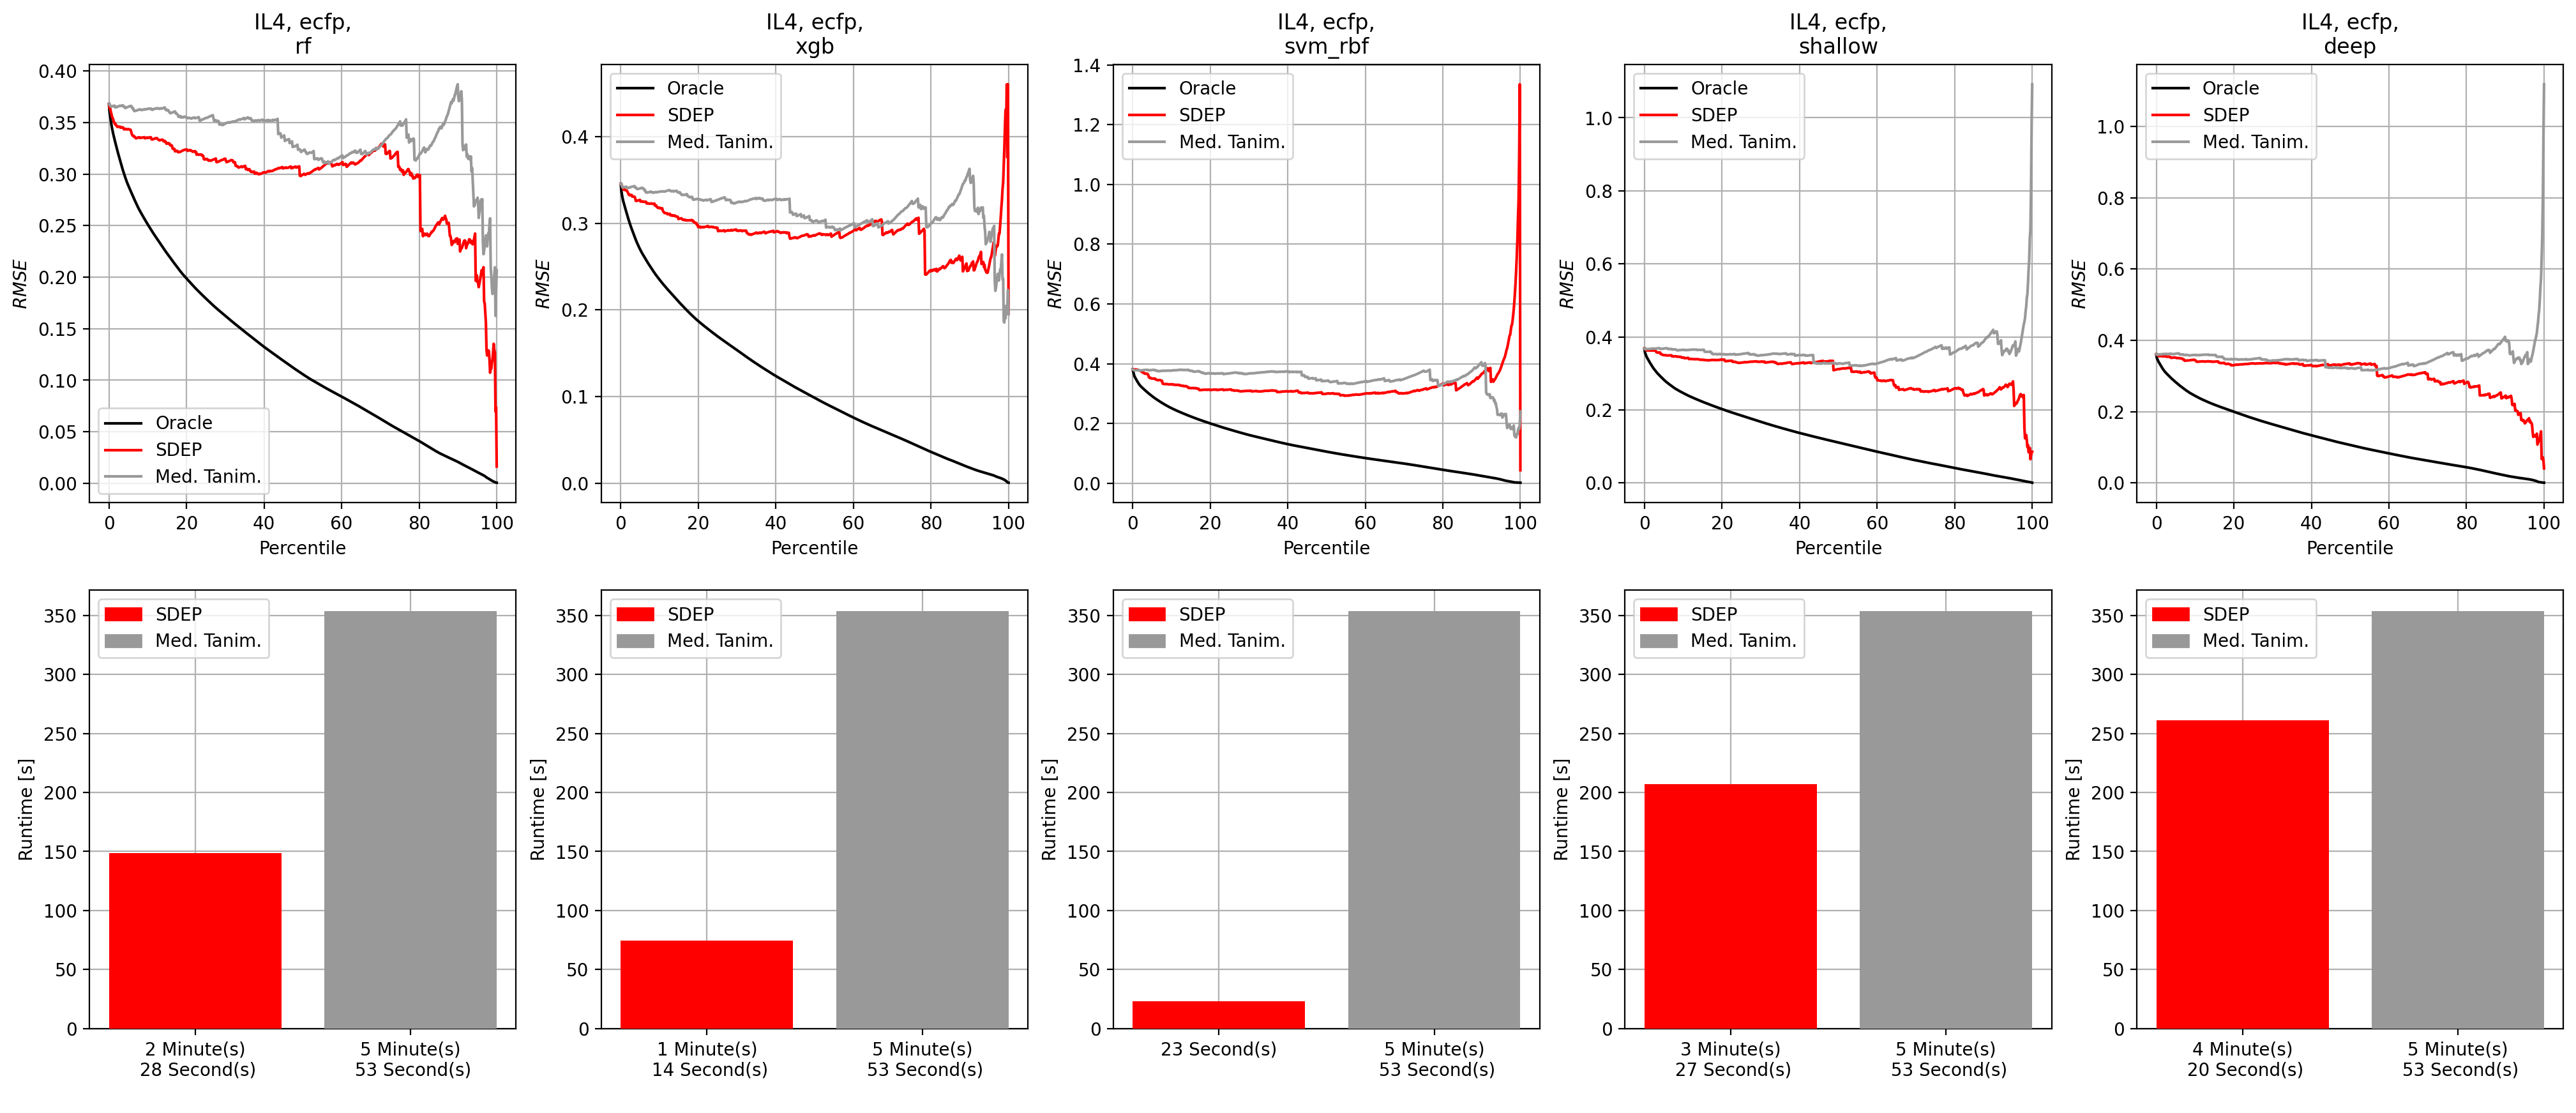

In [18]:
compare_median('IL4', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('IL4', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### P49146, MACCS, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


 20%|██        | 1/5 [00:00<00:00,  6.42it/s]

At xgb.


 60%|██████    | 3/5 [00:00<00:00, 23.10it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


Plotting.


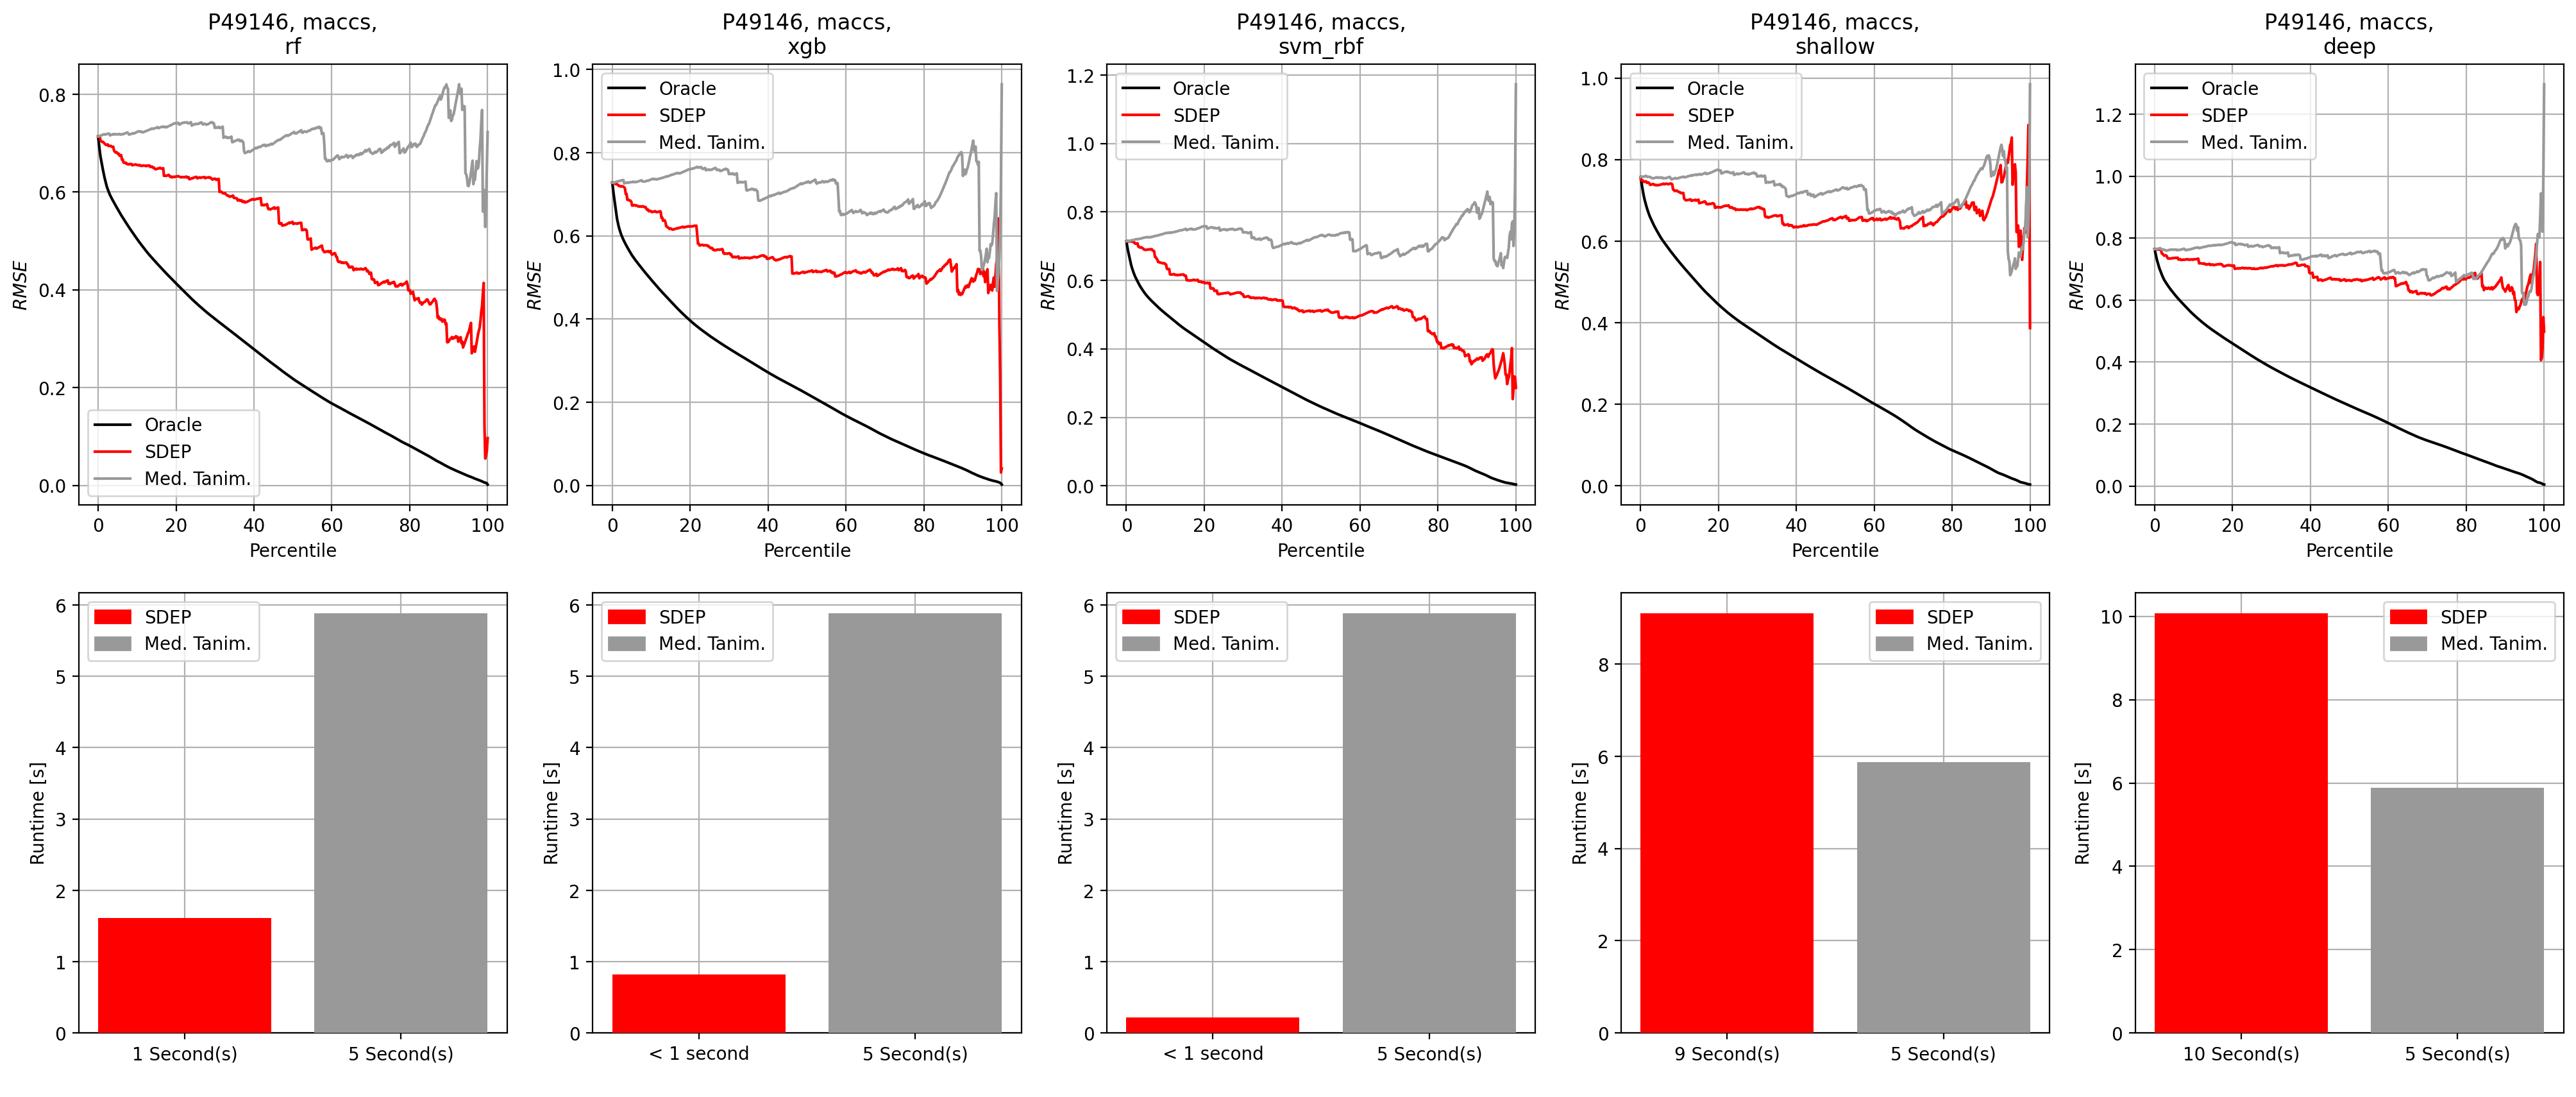

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Tanimoto distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  3%|▎         | 3/100 [00:00<00:04, 23.14it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


Plotting.


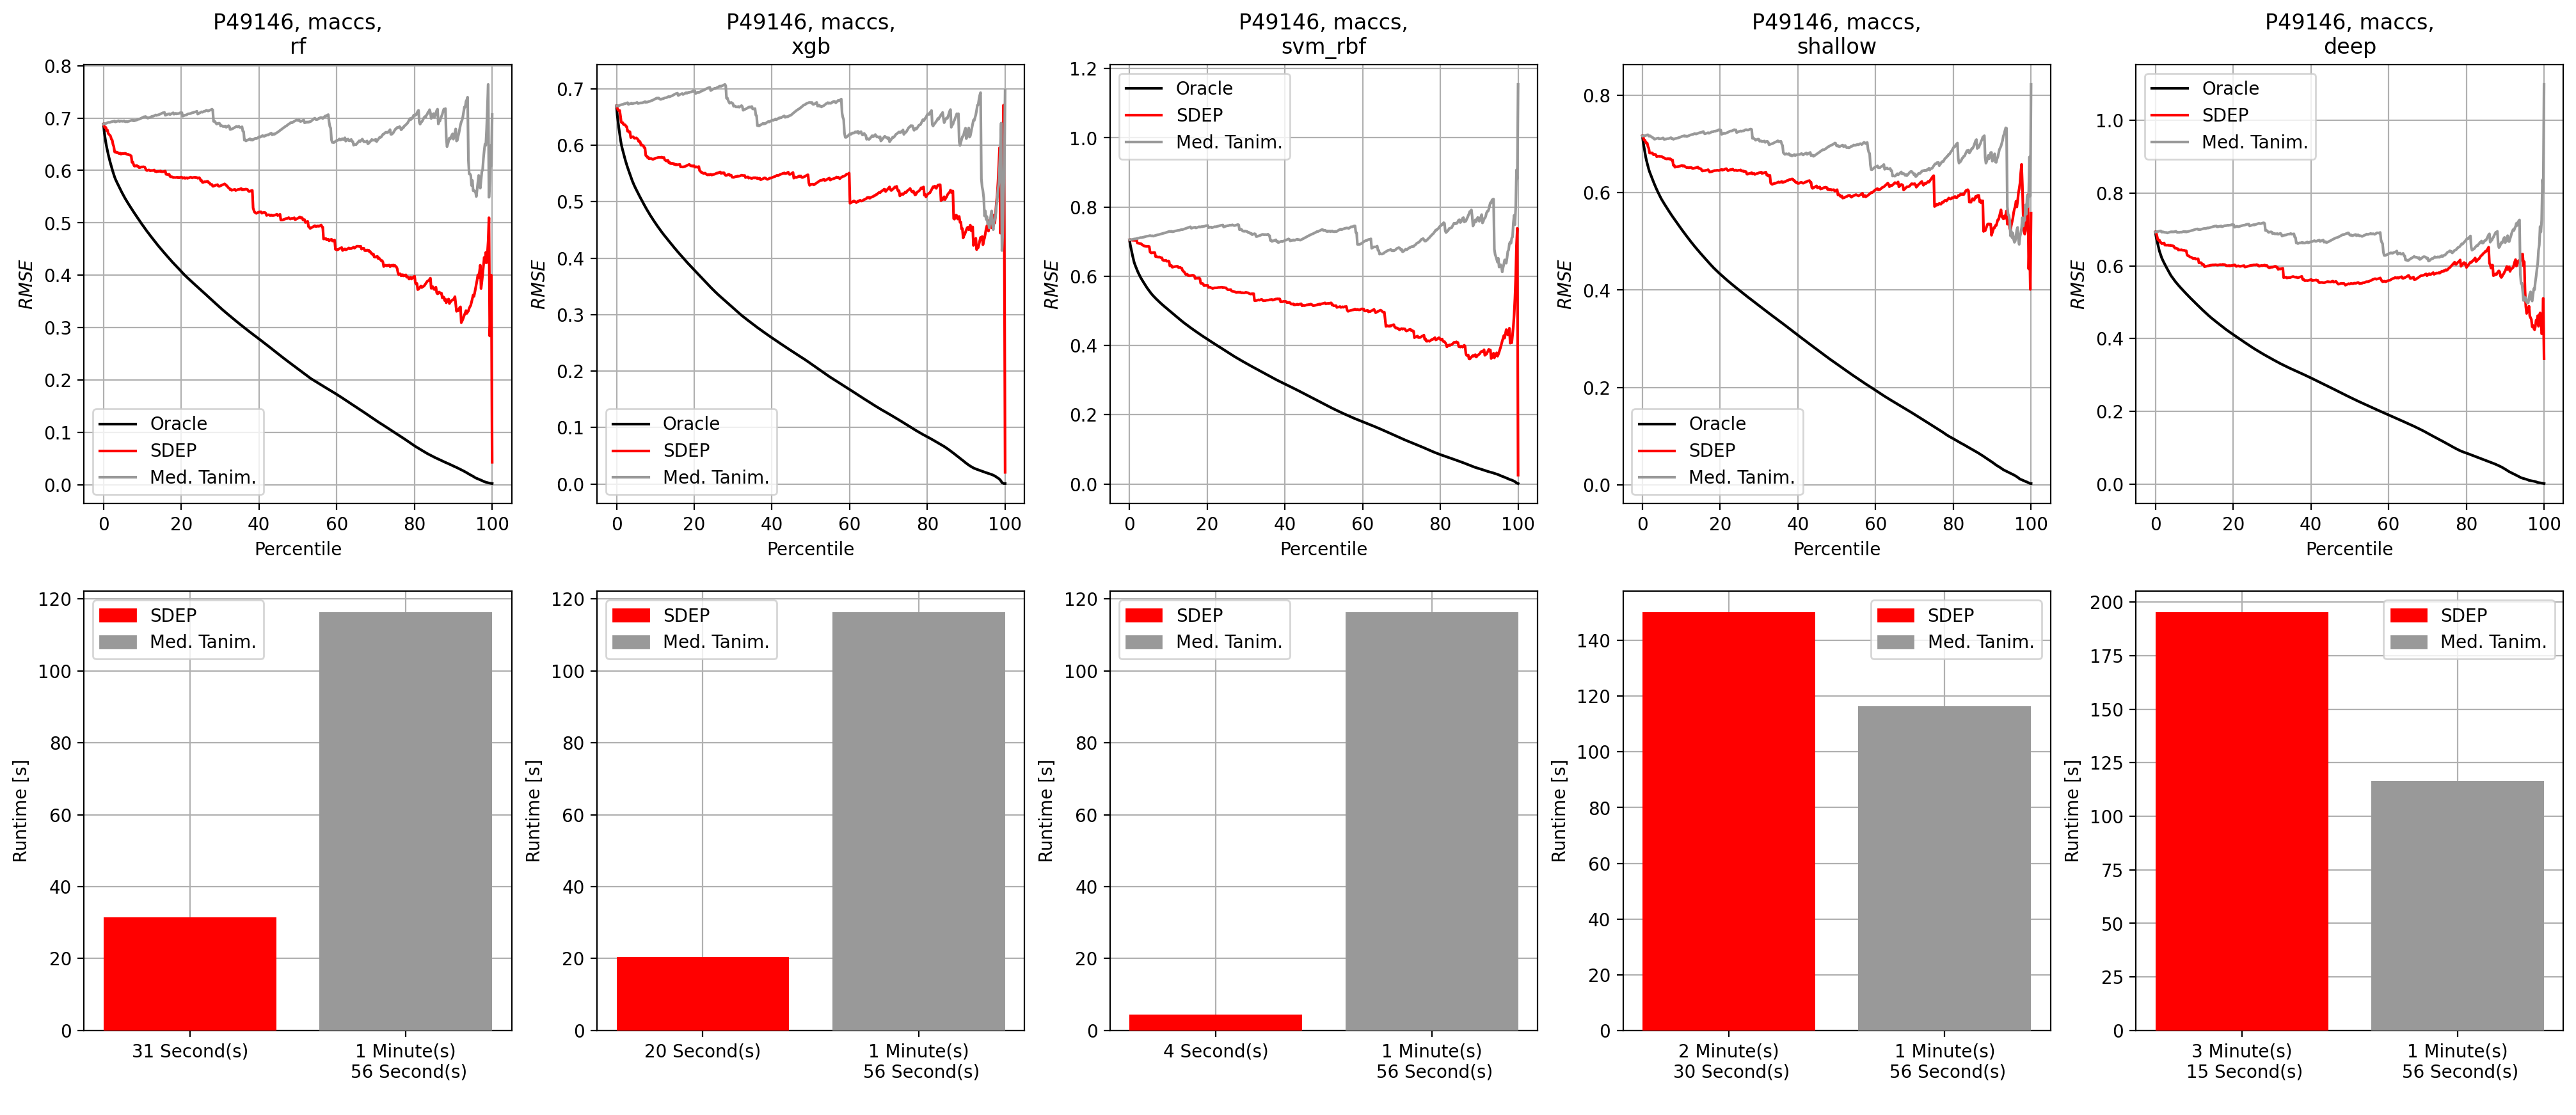

In [19]:
compare_median('P49146', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('P49146', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)